***
# Model Deployment : Estimating Lung Cancer Probabilities From Demographic Factors And Behavioral Indicators

***
### John Pauline Pineda <br> <br> *August 17, 2024*
***

* [**1. Table of Contents**](#TOC)
    * [1.1 Data Background](#1.1)
    * [1.2 Data Description](#1.2)
    * [1.3 Data Quality Assessment](#1.3)
    * [1.4 Data Preprocessing](#1.4)
    * [1.5 Data Exploration](#1.5)
        * [1.5.1 Exploratory Data Analysis](#1.5.1)
        * [1.5.2 Hypothesis Testing](#1.5.2)
    * [1.6 Predictive Model Development](#1.6)
        * [1.6.1 Pre-Modelling Data Preparation](#1.6.1)
        * [1.6.2 Data Splitting](#1.6.2)
        * [1.6.3 Modelling Pipeline Development](#1.6.3)
            * [1.6.3.1 Individual Classifier](#1.6.3.1)
            * [1.6.3.2 Stacked Classifier](#1.6.3.2)
        * [1.6.4 Model Fitting using Upsampled Training Data | Hyperparameter Tuning | Validation](#1.6.4)
            * [1.6.4.1 Individual Classifier](#1.6.4.1)
            * [1.6.4.2 Stacked Classifier](#1.6.4.2)
        * [1.6.5 Model Fitting using Upsampled Training Data | Hyperparameter Tuning | Validation](#1.6.5)
            * [1.6.5.1 Individual Classifier](#1.6.5.1)
            * [1.6.5.2 Stacked Classifier](#1.6.5.2)
        * [1.6.6 Model Fitting using Downsampled Training Data | Hyperparameter Tuning | Validation](#1.6.6)
            * [1.6.6.1 Individual Classifier](#1.6.6.1)
            * [1.6.6.2 Stacked Classifier](#1.6.6.2)
        * [1.6.7 Model Selection](#1.6.7)
        * [1.6.8 Model Testing](#1.6.8)
        * [1.6.9 Model Inference | Interpretation](#1.6.9)
    * [1.7 Consolidated Findings](#1.7)
* [**2. Summary**](#Summary)   
* [**3. References**](#References)

***

# 1. Table of Contents <a class="anchor" id="TOC"></a>

## 1.1. Data Background <a class="anchor" id="1.1"></a>

## 1.2. Data Description <a class="anchor" id="1.2"></a>

In [1]:
##################################
# Setting up compatibility issues
# between the scikit-learn and imblearn packages
##################################
# !pip uninstall scikit-learn --yes
# !pip uninstall imblearn --yes
# !pip install scikit-learn==1.2.2
# !pip install imblearn

In [2]:
##################################
# Loading Python Libraries
##################################
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import itertools
import joblib
%matplotlib inline
import shap

from operator import add,mul,truediv
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer, StandardScaler
from scipy import stats
from scipy.stats import pointbiserialr

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import CondensedNearestNeighbour

In [3]:
##################################
# Defining file paths
##################################
DATASETS_ORIGINAL_PATH = r"datasets\original"
DATASETS_PREPROCESSED_PATH = r"datasets\preprocessed"
DATASETS_FINAL_PATH = r"datasets\final\complete"
DATASETS_FINAL_TRAIN_PATH = r"datasets\final\train"
DATASETS_FINAL_TRAIN_FEATURES_PATH = r"datasets\final\train\features"
DATASETS_FINAL_TRAIN_TARGET_PATH = r"datasets\final\train\target"
DATASETS_FINAL_VALIDATION_PATH = r"datasets\final\validation"
DATASETS_FINAL_VALIDATION_FEATURES_PATH = r"datasets\final\validation\features"
DATASETS_FINAL_VALIDATION_TARGET_PATH = r"datasets\final\validation\target"
DATASETS_FINAL_TEST_PATH = r"datasets\final\test"
DATASETS_FINAL_TEST_FEATURES_PATH = r"datasets\final\test\features"
DATASETS_FINAL_TEST_TARGET_PATH = r"datasets\final\test\target"
MODELS_PATH = r"models"

In [4]:
##################################
# Loading the dataset
# from the DATASETS_ORIGINAL_PATH
##################################
lung_cancer = pd.read_csv(os.path.join("..", DATASETS_ORIGINAL_PATH, "lung_cancer.csv"))

In [5]:
##################################
# Performing a general exploration of the dataset
##################################
print('Dataset Dimensions: ')
display(lung_cancer.shape)

Dataset Dimensions: 


(309, 16)

In [6]:
##################################
# Listing the column names and data types
##################################
print('Column Names and Data Types:')
display(lung_cancer.dtypes)

Column Names and Data Types:


GENDER                   object
AGE                       int64
SMOKING                   int64
YELLOW_FINGERS            int64
ANXIETY                   int64
PEER_PRESSURE             int64
CHRONIC DISEASE           int64
FATIGUE                   int64
ALLERGY                   int64
WHEEZING                  int64
ALCOHOL CONSUMING         int64
COUGHING                  int64
SHORTNESS OF BREATH       int64
SWALLOWING DIFFICULTY     int64
CHEST PAIN                int64
LUNG_CANCER              object
dtype: object

In [7]:
##################################
# Taking a snapshot of the dataset
##################################
lung_cancer.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [8]:
##################################
# Setting the levels of the dichotomous categorical variables
# to boolean values
##################################
lung_cancer[['GENDER','LUNG_CANCER']] = lung_cancer[['GENDER','LUNG_CANCER']].astype('category')
lung_cancer['GENDER'] = lung_cancer['GENDER'].cat.set_categories(['F', 'M'], ordered=True)
lung_cancer['LUNG_CANCER'] = lung_cancer['LUNG_CANCER'].cat.set_categories(['NO', 'YES'], ordered=True)
lung_cancer.iloc[:,2:15] = lung_cancer.iloc[:,2:15].replace({1: 'Absent', 2: 'Present'})

In [9]:
##################################
# Listing the column names and data types
##################################
print('Column Names and Data Types:')
display(lung_cancer.dtypes)

Column Names and Data Types:


GENDER                   category
AGE                         int64
SMOKING                    object
YELLOW_FINGERS             object
ANXIETY                    object
PEER_PRESSURE              object
CHRONIC DISEASE            object
FATIGUE                    object
ALLERGY                    object
WHEEZING                   object
ALCOHOL CONSUMING          object
COUGHING                   object
SHORTNESS OF BREATH        object
SWALLOWING DIFFICULTY      object
CHEST PAIN                 object
LUNG_CANCER              category
dtype: object

In [10]:
##################################
# Taking a snapshot of the dataset
##################################
lung_cancer.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,Absent,Present,Present,Absent,Absent,Present,Absent,Present,Present,Present,Present,Present,Present,YES
1,M,74,Present,Absent,Absent,Absent,Present,Present,Present,Absent,Absent,Absent,Present,Present,Present,YES
2,F,59,Absent,Absent,Absent,Present,Absent,Present,Absent,Present,Absent,Present,Present,Absent,Present,NO
3,M,63,Present,Present,Present,Absent,Absent,Absent,Absent,Absent,Present,Absent,Absent,Present,Present,NO
4,F,63,Absent,Present,Absent,Absent,Absent,Absent,Absent,Present,Absent,Present,Present,Absent,Absent,NO


In [11]:
##################################
# Performing a general exploration 
# of the numeric variables
##################################
print('Numeric Variable Summary:')
display(lung_cancer.describe(include='number').transpose())

Numeric Variable Summary:


,count,mean,std,min,25%,50%,75%,max
AGE,309.0,62.673139,8.210301,21.0,57.0,62.0,69.0,87.0


In [12]:
##################################
# Performing a general exploration 
# of the object and categorical variables
##################################
print('Categorical Variable Summary:')
display(lung_cancer.describe(include=['category','object']).transpose())

Categorical Variable Summary:


,count,unique,top,freq
GENDER,309,2,M,162
SMOKING,309,2,Present,174
YELLOW_FINGERS,309,2,Present,176
ANXIETY,309,2,Absent,155
PEER_PRESSURE,309,2,Present,155
CHRONIC DISEASE,309,2,Present,156
FATIGUE,309,2,Present,208
ALLERGY,309,2,Present,172
WHEEZING,309,2,Present,172
ALCOHOL CONSUMING,309,2,Present,172


## 1.3. Data Quality Assessment <a class="anchor" id="1.3"></a>

In [13]:
##################################
# Counting the number of duplicated rows
##################################
lung_cancer.duplicated().sum()

33

In [14]:
##################################
# Gathering the data types for each column
##################################
data_type_list = list(lung_cancer.dtypes)

In [15]:
##################################
# Gathering the variable names for each column
##################################
variable_name_list = list(lung_cancer.columns)

In [16]:
##################################
# Gathering the number of observations for each column
##################################
row_count_list = list([len(lung_cancer)] * len(lung_cancer.columns))

In [17]:
##################################
# Gathering the number of missing data for each column
##################################
null_count_list = list(lung_cancer.isna().sum(axis=0))

In [18]:
##################################
# Gathering the number of non-missing data for each column
##################################
non_null_count_list = list(lung_cancer.count())

In [19]:
##################################
# Gathering the missing data percentage for each column
##################################
fill_rate_list = map(truediv, non_null_count_list, row_count_list)

In [20]:
##################################
# Formulating the summary
# for all columns
##################################
all_column_quality_summary = pd.DataFrame(zip(variable_name_list,
                                              data_type_list,
                                              row_count_list,
                                              non_null_count_list,
                                              null_count_list,
                                              fill_rate_list), 
                                        columns=['Column.Name',
                                                 'Column.Type',
                                                 'Row.Count',
                                                 'Non.Null.Count',
                                                 'Null.Count',                                                 
                                                 'Fill.Rate'])
display(all_column_quality_summary)

,Column.Name,Column.Type,Row.Count,Non.Null.Count,Null.Count,Fill.Rate
0,GENDER,category,309,309,0,1.0
1,AGE,int64,309,309,0,1.0
2,SMOKING,object,309,309,0,1.0
3,YELLOW_FINGERS,object,309,309,0,1.0
4,ANXIETY,object,309,309,0,1.0
5,PEER_PRESSURE,object,309,309,0,1.0
6,CHRONIC DISEASE,object,309,309,0,1.0
7,FATIGUE,object,309,309,0,1.0
8,ALLERGY,object,309,309,0,1.0
9,WHEEZING,object,309,309,0,1.0


In [21]:
##################################
# Counting the number of columns
# with Fill.Rate < 1.00
##################################
print('Number of Columns with Missing Data:', str(len(all_column_quality_summary[(all_column_quality_summary['Fill.Rate']<1)])))

Number of Columns with Missing Data: 0


In [22]:
##################################
# Identifying the rows
# with Fill.Rate < 1.00
##################################
column_low_fill_rate = all_column_quality_summary[(all_column_quality_summary['Fill.Rate']<1.00)]

In [23]:
##################################
# Gathering the metadata labels for each observation
##################################
row_metadata_list = lung_cancer.index.values.tolist()

In [24]:
##################################
# Gathering the number of columns for each observation
##################################
column_count_list = list([len(lung_cancer.columns)] * len(lung_cancer))

In [25]:
##################################
# Gathering the number of missing data for each row
##################################
null_row_list = list(lung_cancer.isna().sum(axis=1))

In [26]:
##################################
# Gathering the missing data percentage for each column
##################################
missing_rate_list = map(truediv, null_row_list, column_count_list)

In [27]:
##################################
# Exploring the rows
# for missing data
##################################
all_row_quality_summary = pd.DataFrame(zip(row_metadata_list,
                                           column_count_list,
                                           null_row_list,
                                           missing_rate_list), 
                                        columns=['Row.Name',
                                                 'Column.Count',
                                                 'Null.Count',                                                 
                                                 'Missing.Rate'])
display(all_row_quality_summary)

,Row.Name,Column.Count,Null.Count,Missing.Rate
0,0,16,0,0.0
1,1,16,0,0.0
2,2,16,0,0.0
3,3,16,0,0.0
4,4,16,0,0.0
...,...,...,...,...
304,304,16,0,0.0
305,305,16,0,0.0
306,306,16,0,0.0
307,307,16,0,0.0


In [28]:
##################################
# Counting the number of rows
# with Fill.Rate < 1.00
##################################
print('Number of Rows with Missing Data:',str(len(all_row_quality_summary[all_row_quality_summary['Missing.Rate']>0])))

Number of Rows with Missing Data: 0


In [29]:
##################################
# Formulating the dataset
# with numeric columns only
##################################
lung_cancer_numeric = lung_cancer.select_dtypes(include=['number','int'])

In [30]:
##################################
# Gathering the variable names for each numeric column
##################################
numeric_variable_name_list = lung_cancer_numeric.columns

In [31]:
##################################
# Gathering the minimum value for each numeric column
##################################
numeric_minimum_list = lung_cancer_numeric.min()

In [32]:
##################################
# Gathering the mean value for each numeric column
##################################
numeric_mean_list = lung_cancer_numeric.mean()

In [33]:
##################################
# Gathering the median value for each numeric column
##################################
numeric_median_list = lung_cancer_numeric.median()

In [34]:
##################################
# Gathering the maximum value for each numeric column
##################################
numeric_maximum_list = lung_cancer_numeric.max()

In [35]:
##################################
# Gathering the first mode values for each numeric column
##################################
numeric_first_mode_list = [lung_cancer[x].value_counts(dropna=True).index.tolist()[0] for x in lung_cancer_numeric]

In [36]:
##################################
# Gathering the second mode values for each numeric column
##################################
numeric_second_mode_list = [lung_cancer[x].value_counts(dropna=True).index.tolist()[1] for x in lung_cancer_numeric]

In [37]:
##################################
# Gathering the count of first mode values for each numeric column
##################################
numeric_first_mode_count_list = [lung_cancer_numeric[x].isin([lung_cancer[x].value_counts(dropna=True).index.tolist()[0]]).sum() for x in lung_cancer_numeric]

In [38]:
##################################
# Gathering the count of second mode values for each numeric column
##################################
numeric_second_mode_count_list = [lung_cancer_numeric[x].isin([lung_cancer[x].value_counts(dropna=True).index.tolist()[1]]).sum() for x in lung_cancer_numeric]

In [39]:
##################################
# Gathering the first mode to second mode ratio for each numeric column
##################################
numeric_first_second_mode_ratio_list = map(truediv, numeric_first_mode_count_list, numeric_second_mode_count_list)

In [40]:
##################################
# Gathering the count of unique values for each numeric column
##################################
numeric_unique_count_list = lung_cancer_numeric.nunique(dropna=True)

In [41]:
##################################
# Gathering the number of observations for each numeric column
##################################
numeric_row_count_list = list([len(lung_cancer_numeric)] * len(lung_cancer_numeric.columns))

In [42]:
##################################
# Gathering the unique to count ratio for each numeric column
##################################
numeric_unique_count_ratio_list = map(truediv, numeric_unique_count_list, numeric_row_count_list)

In [43]:
##################################
# Gathering the skewness value for each numeric column
##################################
numeric_skewness_list = lung_cancer_numeric.skew()

In [44]:
##################################
# Gathering the kurtosis value for each numeric column
##################################
numeric_kurtosis_list = lung_cancer_numeric.kurtosis()

In [45]:
numeric_column_quality_summary = pd.DataFrame(zip(numeric_variable_name_list,
                                                numeric_minimum_list,
                                                numeric_mean_list,
                                                numeric_median_list,
                                                numeric_maximum_list,
                                                numeric_first_mode_list,
                                                numeric_second_mode_list,
                                                numeric_first_mode_count_list,
                                                numeric_second_mode_count_list,
                                                numeric_first_second_mode_ratio_list,
                                                numeric_unique_count_list,
                                                numeric_row_count_list,
                                                numeric_unique_count_ratio_list,
                                                numeric_skewness_list,
                                                numeric_kurtosis_list), 
                                        columns=['Numeric.Column.Name',
                                                 'Minimum',
                                                 'Mean',
                                                 'Median',
                                                 'Maximum',
                                                 'First.Mode',
                                                 'Second.Mode',
                                                 'First.Mode.Count',
                                                 'Second.Mode.Count',
                                                 'First.Second.Mode.Ratio',
                                                 'Unique.Count',
                                                 'Row.Count',
                                                 'Unique.Count.Ratio',
                                                 'Skewness',
                                                 'Kurtosis'])
display(numeric_column_quality_summary)

,Numeric.Column.Name,Minimum,Mean,Median,Maximum,First.Mode,Second.Mode,First.Mode.Count,Second.Mode.Count,First.Second.Mode.Ratio,Unique.Count,Row.Count,Unique.Count.Ratio,Skewness,Kurtosis
0,AGE,21,62.673139,62.0,87,64,63,20,19,1.052632,39,309,0.126214,-0.395086,1.746558


In [46]:
##################################
# Counting the number of numeric columns
# with First.Second.Mode.Ratio > 5.00
##################################
len(numeric_column_quality_summary[(numeric_column_quality_summary['First.Second.Mode.Ratio']>5)])

0

In [47]:
##################################
# Counting the number of numeric columns
# with Unique.Count.Ratio > 10.00
##################################
len(numeric_column_quality_summary[(numeric_column_quality_summary['Unique.Count.Ratio']>10)])

0

In [48]:
##################################
# Counting the number of numeric columns
# with Skewness > 3.00 or Skewness < -3.00
##################################
len(numeric_column_quality_summary[(numeric_column_quality_summary['Skewness']>3) | (numeric_column_quality_summary['Skewness']<(-3))])

0

In [49]:
##################################
# Formulating the dataset
# with object or categorical column only
##################################
lung_cancer_object = lung_cancer.select_dtypes(include=['object','category'])

In [50]:
##################################
# Gathering the variable names for the object or categorical column
##################################
categorical_variable_name_list = lung_cancer_object.columns

In [51]:
##################################
# Gathering the first mode values for the object or categorical column
##################################
categorical_first_mode_list = [lung_cancer[x].value_counts().index.tolist()[0] for x in lung_cancer_object]

In [52]:
##################################
# Gathering the second mode values for each object or categorical column
##################################
categorical_second_mode_list = [lung_cancer[x].value_counts().index.tolist()[1] for x in lung_cancer_object]

In [53]:
##################################
# Gathering the count of first mode values for each object or categorical column
##################################
categorical_first_mode_count_list = [lung_cancer_object[x].isin([lung_cancer[x].value_counts(dropna=True).index.tolist()[0]]).sum() for x in lung_cancer_object]

In [54]:
##################################
# Gathering the count of second mode values for each object or categorical column
##################################
categorical_second_mode_count_list = [lung_cancer_object[x].isin([lung_cancer[x].value_counts(dropna=True).index.tolist()[1]]).sum() for x in lung_cancer_object]

In [55]:
##################################
# Gathering the first mode to second mode ratio for each object or categorical column
##################################
categorical_first_second_mode_ratio_list = map(truediv, categorical_first_mode_count_list, categorical_second_mode_count_list)

In [56]:
##################################
# Gathering the count of unique values for each object or categorical column
##################################
categorical_unique_count_list = lung_cancer_object.nunique(dropna=True)

In [57]:
##################################
# Gathering the number of observations for each object or categorical column
##################################
categorical_row_count_list = list([len(lung_cancer_object)] * len(lung_cancer_object.columns))

In [58]:
##################################
# Gathering the unique to count ratio for each object or categorical column
##################################
categorical_unique_count_ratio_list = map(truediv, categorical_unique_count_list, categorical_row_count_list)

In [59]:
categorical_column_quality_summary = pd.DataFrame(zip(categorical_variable_name_list,
                                                 categorical_first_mode_list,
                                                 categorical_second_mode_list,
                                                 categorical_first_mode_count_list,
                                                 categorical_second_mode_count_list,
                                                 categorical_first_second_mode_ratio_list,
                                                 categorical_unique_count_list,
                                                 categorical_row_count_list,
                                                 categorical_unique_count_ratio_list), 
                                        columns=['Categorical.Column.Name',
                                                 'First.Mode',
                                                 'Second.Mode',
                                                 'First.Mode.Count',
                                                 'Second.Mode.Count',
                                                 'First.Second.Mode.Ratio',
                                                 'Unique.Count',
                                                 'Row.Count',
                                                 'Unique.Count.Ratio'])
display(categorical_column_quality_summary)

,Categorical.Column.Name,First.Mode,Second.Mode,First.Mode.Count,Second.Mode.Count,First.Second.Mode.Ratio,Unique.Count,Row.Count,Unique.Count.Ratio
0,GENDER,M,F,162,147,1.102041,2,309,0.006472
1,SMOKING,Present,Absent,174,135,1.288889,2,309,0.006472
2,YELLOW_FINGERS,Present,Absent,176,133,1.323308,2,309,0.006472
3,ANXIETY,Absent,Present,155,154,1.006494,2,309,0.006472
4,PEER_PRESSURE,Present,Absent,155,154,1.006494,2,309,0.006472
5,CHRONIC DISEASE,Present,Absent,156,153,1.019608,2,309,0.006472
6,FATIGUE,Present,Absent,208,101,2.059406,2,309,0.006472
7,ALLERGY,Present,Absent,172,137,1.255474,2,309,0.006472
8,WHEEZING,Present,Absent,172,137,1.255474,2,309,0.006472
9,ALCOHOL CONSUMING,Present,Absent,172,137,1.255474,2,309,0.006472


In [60]:
##################################
# Counting the number of object or categorical columns
# with First.Second.Mode.Ratio > 5.00
##################################
len(categorical_column_quality_summary[(categorical_column_quality_summary['First.Second.Mode.Ratio']>5)])

1

In [61]:
##################################
# Identifying the object or categorical columns
# with First.Second.Mode.Ratio > 5.00
##################################
display(categorical_column_quality_summary[(categorical_column_quality_summary['First.Second.Mode.Ratio']>5)].sort_values(by=['First.Second.Mode.Ratio'], ascending=False))

,Categorical.Column.Name,First.Mode,Second.Mode,First.Mode.Count,Second.Mode.Count,First.Second.Mode.Ratio,Unique.Count,Row.Count,Unique.Count.Ratio
14,LUNG_CANCER,YES,NO,270,39,6.923077,2,309,0.006472


In [62]:
##################################
# Counting the number of object or categorical columns
# with Unique.Count.Ratio > 10.00
##################################
len(categorical_column_quality_summary[(categorical_column_quality_summary['Unique.Count.Ratio']>10)])

0

## 1.4. Data Preprocessing <a class="anchor" id="1.4"></a>

In [63]:
##################################
# Formulating the dataset
# with numeric columns only
##################################
lung_cancer_numeric = lung_cancer.select_dtypes(include=['number','int'])

In [64]:
##################################
# Gathering the variable names for each numeric column
##################################
numeric_variable_name_list = lung_cancer_numeric.columns

In [65]:
##################################
# Gathering the skewness value for each numeric column
##################################
numeric_skewness_list = lung_cancer_numeric.skew()

In [66]:
##################################
# Computing the interquartile range
# for all columns
##################################
lung_cancer_numeric_q1 = lung_cancer_numeric.quantile(0.25)
lung_cancer_numeric_q3 = lung_cancer_numeric.quantile(0.75)
lung_cancer_numeric_iqr = lung_cancer_numeric_q3 - lung_cancer_numeric_q1

In [67]:
##################################
# Gathering the outlier count for each numeric column
# based on the interquartile range criterion
##################################
numeric_outlier_count_list = ((lung_cancer_numeric < (lung_cancer_numeric_q1 - 1.5 * lung_cancer_numeric_iqr)) | (lung_cancer_numeric > (lung_cancer_numeric_q3 + 1.5 * lung_cancer_numeric_iqr))).sum()

In [68]:
##################################
# Gathering the number of observations for each column
##################################
numeric_row_count_list = list([len(lung_cancer_numeric)] * len(lung_cancer_numeric.columns))

In [69]:
##################################
# Gathering the unique to count ratio for each categorical column
##################################
numeric_outlier_ratio_list = map(truediv, numeric_outlier_count_list, numeric_row_count_list)

In [70]:
##################################
# Formulating the outlier summary
# for all numeric columns
##################################
numeric_column_outlier_summary = pd.DataFrame(zip(numeric_variable_name_list,
                                                  numeric_skewness_list,
                                                  numeric_outlier_count_list,
                                                  numeric_row_count_list,
                                                  numeric_outlier_ratio_list), 
                                        columns=['Numeric.Column.Name',
                                                 'Skewness',
                                                 'Outlier.Count',
                                                 'Row.Count',
                                                 'Outlier.Ratio'])
display(numeric_column_outlier_summary)

,Numeric.Column.Name,Skewness,Outlier.Count,Row.Count,Outlier.Ratio
0,AGE,-0.395086,2,309,0.006472


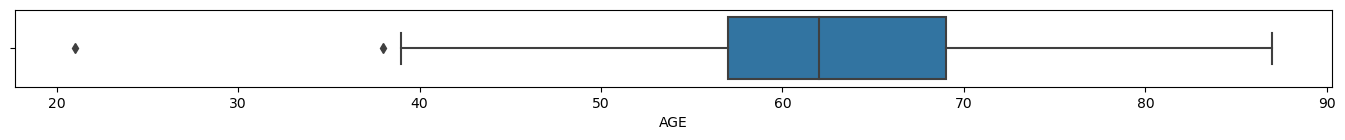

In [71]:
##################################
# Formulating the individual boxplots
# for all numeric columns
##################################
for column in lung_cancer_numeric:
        plt.figure(figsize=(17,1))
        sns.boxplot(data=lung_cancer_numeric, x=column)

In [72]:
##################################
# Creating a dataset copy and
# converting all values to numeric
# for correlation analysis
##################################
lung_cancer_correlation = lung_cancer.copy()
lung_cancer_correlation_object = lung_cancer_correlation.iloc[:,2:15].columns
lung_cancer_correlation[lung_cancer_correlation_object] = lung_cancer_correlation[lung_cancer_correlation_object].replace({'Absent': 0, 'Present': 1})
lung_cancer_correlation = lung_cancer_correlation.drop(['GENDER','LUNG_CANCER'], axis=1)
display(lung_cancer_correlation)

,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN
0,69,0,1,1,0,0,1,0,1,1,1,1,1,1
1,74,1,0,0,0,1,1,1,0,0,0,1,1,1
2,59,0,0,0,1,0,1,0,1,0,1,1,0,1
3,63,1,1,1,0,0,0,0,0,1,0,0,1,1
4,63,0,1,0,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,56,0,0,0,1,1,1,0,0,1,1,1,1,0
305,70,1,0,0,0,0,1,1,1,1,1,1,0,1
306,58,1,0,0,0,0,0,1,1,1,1,0,0,1
307,67,1,0,1,0,0,1,1,0,1,1,1,0,1


In [73]:
##################################
# Initializing the correlation matrix
##################################
lung_cancer_correlation_matrix = pd.DataFrame(np.zeros((len(lung_cancer_correlation.columns), len(lung_cancer_correlation.columns))),
                                              columns=lung_cancer_correlation.columns,
                                              index=lung_cancer_correlation.columns)

In [74]:
##################################
# Calculating different types
# of correlation coefficients
# per variable type
##################################
for i in range(len(lung_cancer_correlation.columns)):
    for j in range(i, len(lung_cancer_correlation.columns)):
        if i == j:
            lung_cancer_correlation_matrix.iloc[i, j] = 1.0
        else:
            if lung_cancer_correlation.dtypes[i] == 'int64' and lung_cancer_correlation.dtypes[j] == 'int64':
                # Pearson correlation for two continuous variables
                corr = lung_cancer_correlation.iloc[:, i].corr(lung_cancer_correlation.iloc[:, j])
            elif lung_cancer_correlation.dtypes[i] == 'int64' or lung_cancer_correlation.dtypes[j] == 'int64':
                # Point-biserial correlation for one continuous and one binary variable
                continuous_var = lung_cancer_correlation.iloc[:, i] if lung_cancer_correlation.dtypes[i] == 'int64' else lung_cancer_correlation.iloc[:, j]
                binary_var = lung_cancer_correlation.iloc[:, j] if lung_cancer_correlation.dtypes[j] == 'int64' else lung_cancer_correlation.iloc[:, i]
                corr, _ = pointbiserialr(continuous_var, binary_var)
            else:
                # Phi coefficient for two binary variables
                corr = lung_cancer_correlation.iloc[:, i].corr(lung_cancer_correlation.iloc[:, j])
            lung_cancer_correlation_matrix.iloc[i, j] = corr
            lung_cancer_correlation_matrix.iloc[j, i] = corr

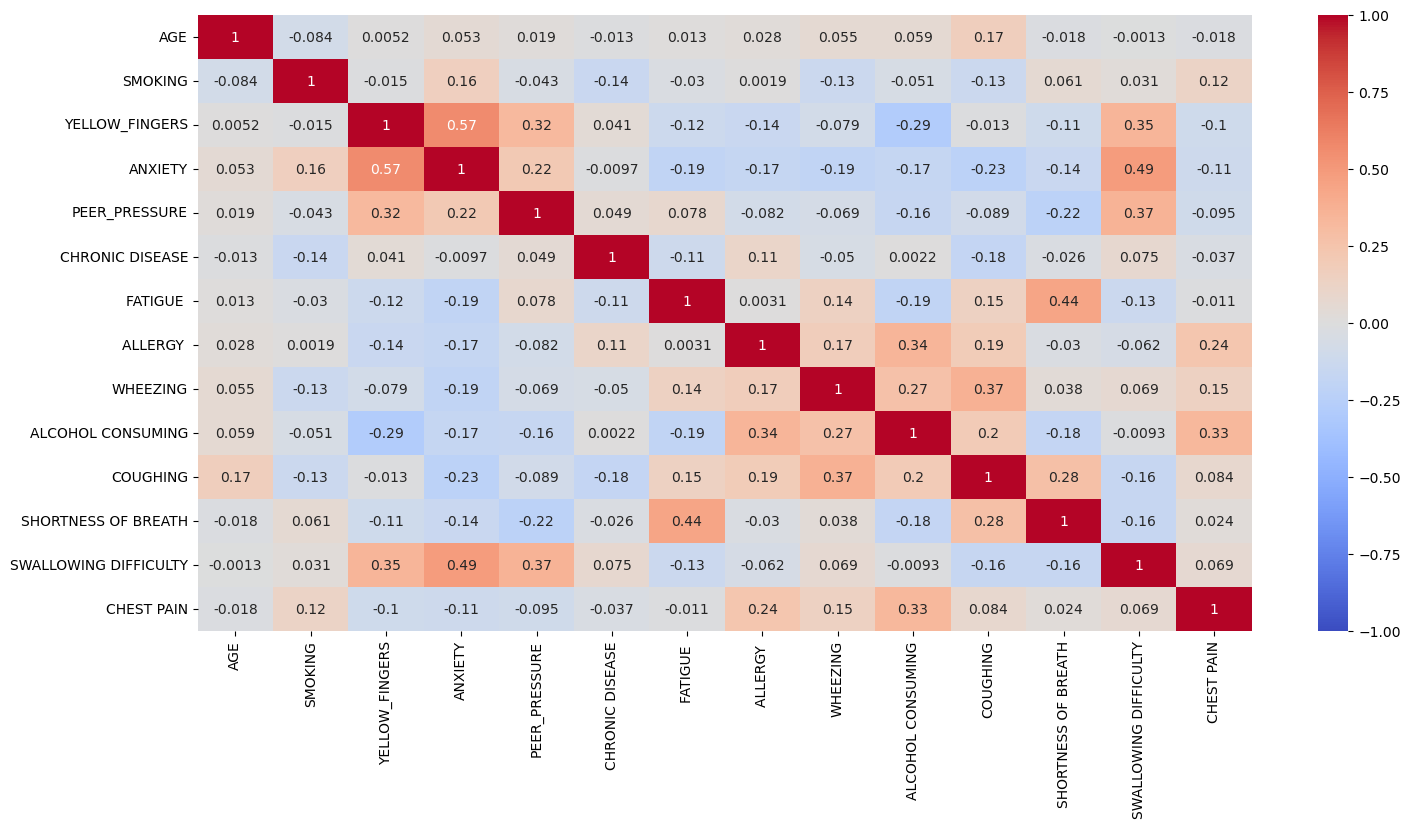

In [75]:
##################################
# Plotting the correlation matrix
# for all pairwise combinations
# of numeric and categorical columns
##################################
plt.figure(figsize=(17, 8))
sns.heatmap(lung_cancer_correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

## 1.5. Data Exploration <a class="anchor" id="1.5"></a>

### 1.5.1 Exploratory Data Analysis <a class="anchor" id="1.5.1"></a>

In [76]:
##################################
# Segregating the target
# and predictor variables
##################################
lung_cancer_predictors = lung_cancer.iloc[:,:-1].columns
lung_cancer_predictors_numeric = lung_cancer.iloc[:,:-1].loc[:,lung_cancer.iloc[:,:-1].columns == 'AGE'].columns
lung_cancer_predictors_categorical = lung_cancer.iloc[:,:-1].loc[:,lung_cancer.iloc[:,:-1].columns != 'AGE'].columns

In [77]:
##################################
# Segregating the target variable
# and numeric predictors
##################################
boxplot_y_variable = 'LUNG_CANCER'
boxplot_x_variable = lung_cancer_predictors_numeric.values[0]

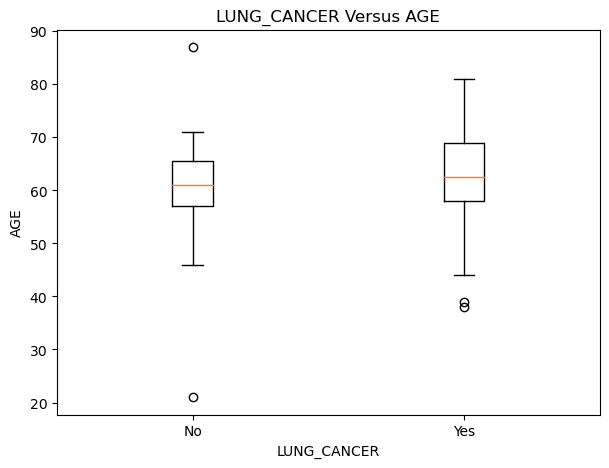

In [78]:
##################################
# Evaluating the numeric predictors
# against the target variable
##################################
plt.figure(figsize=(7, 5))
plt.boxplot([group[boxplot_x_variable] for name, group in lung_cancer.groupby(boxplot_y_variable)])
plt.title(f'{boxplot_y_variable} Versus {boxplot_x_variable}')
plt.xlabel(boxplot_y_variable)
plt.ylabel(boxplot_x_variable)
plt.xticks(range(1, len(lung_cancer[boxplot_y_variable].unique()) + 1), ['No', 'Yes'])
plt.show()

In [79]:
##################################
# Segregating the target variable
# and categorical predictors
##################################
proportion_y_variables = lung_cancer_predictors_categorical
proportion_x_variable = 'LUNG_CANCER'

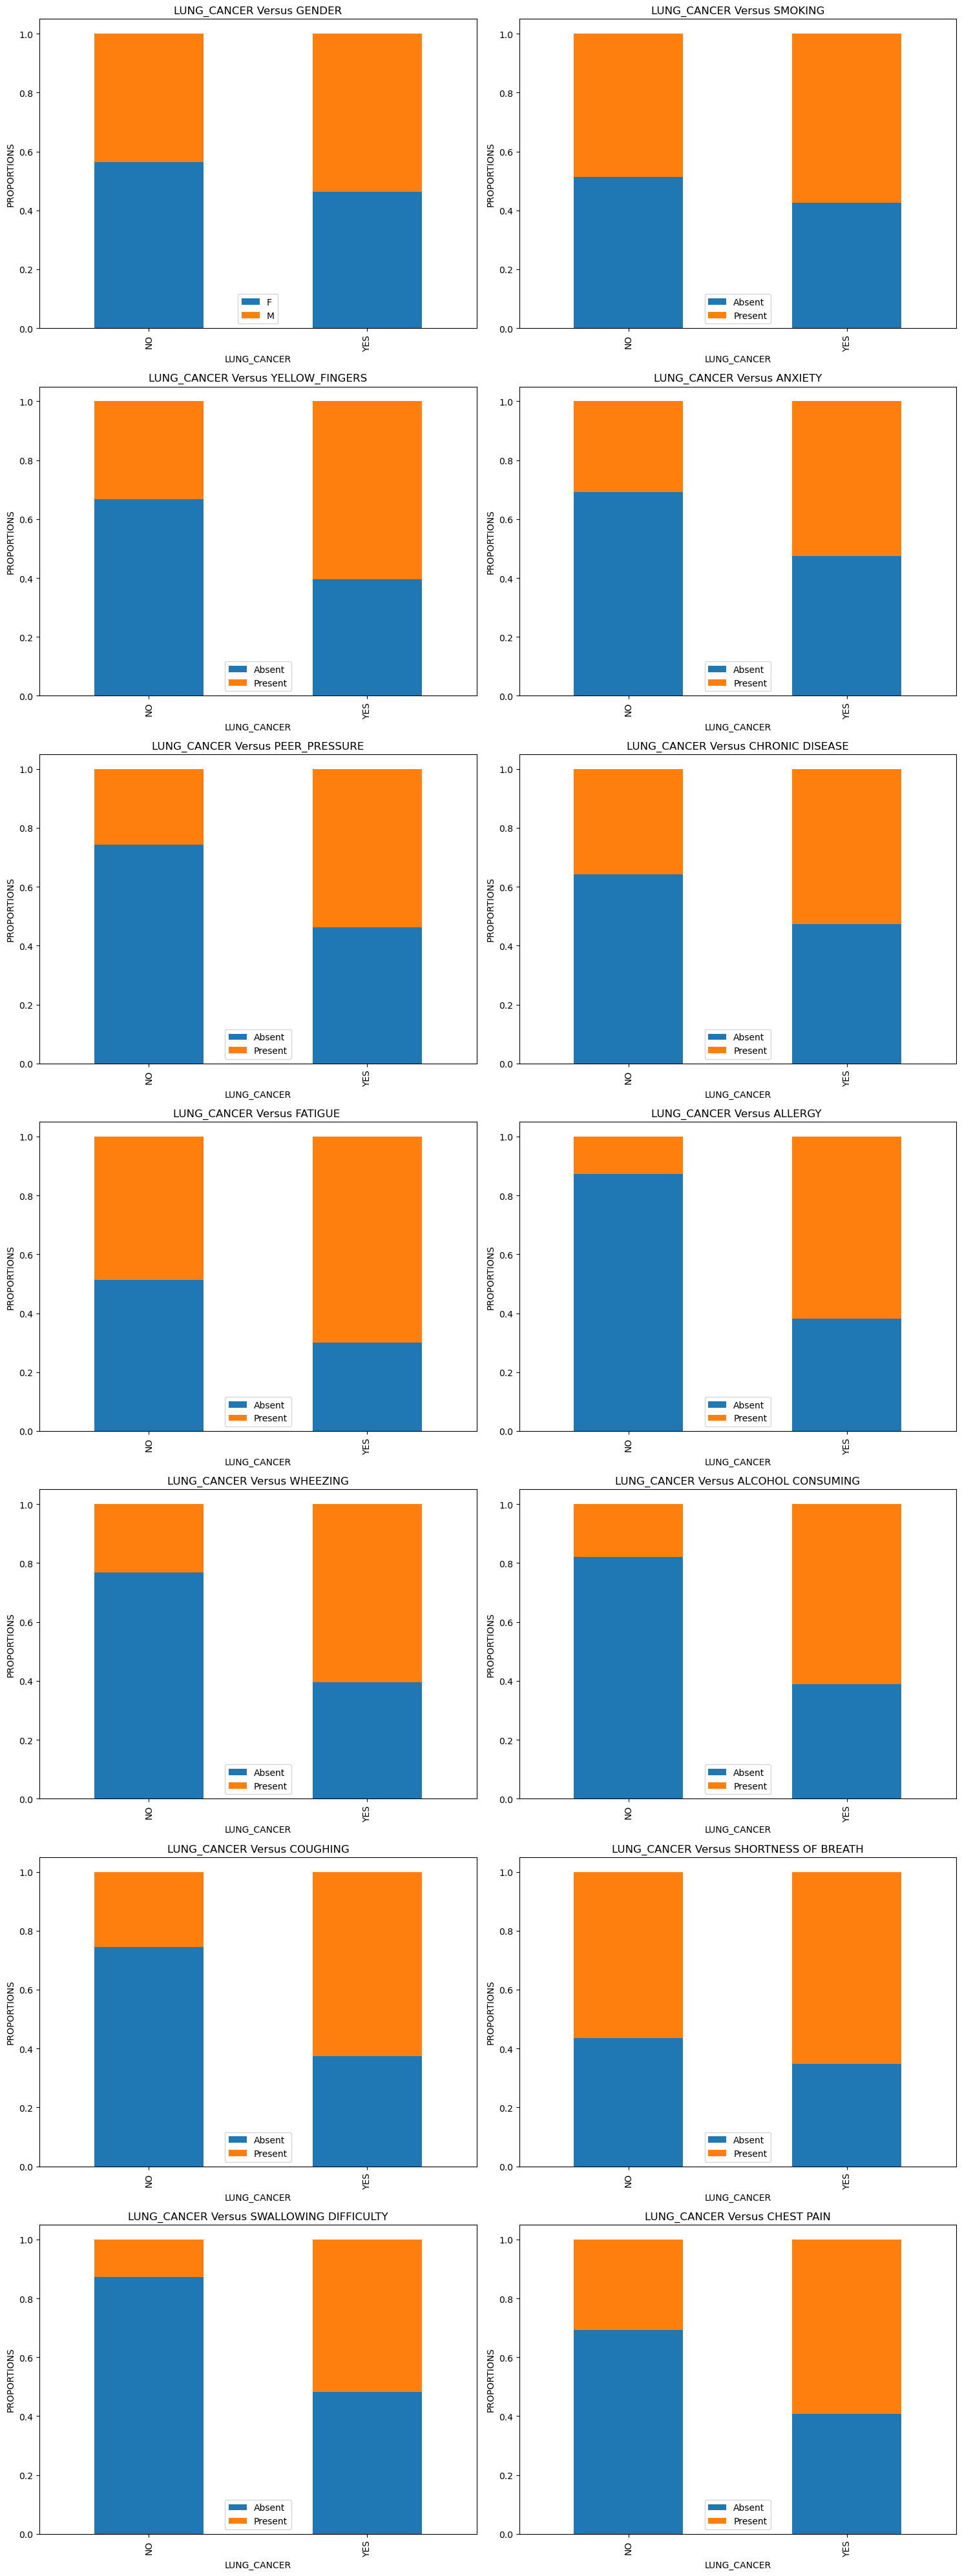

In [80]:
##################################
# Defining the number of 
# rows and columns for the subplots
##################################
num_rows = 7
num_cols = 2

##################################
# Formulating the subplot structure
##################################
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 40))

##################################
# Flattening the multi-row and
# multi-column axes
##################################
axes = axes.ravel()

##################################
# Formulating the individual stacked column plots
# for all categorical columns
##################################
for i, y_variable in enumerate(proportion_y_variables):
    ax = axes[i]
    category_counts = lung_cancer.groupby([proportion_x_variable, y_variable]).size().unstack(fill_value=0)
    category_proportions = category_counts.div(category_counts.sum(axis=1), axis=0)
    category_proportions.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(f'{proportion_x_variable} Versus {y_variable}')
    ax.set_xlabel(proportion_x_variable)
    ax.set_ylabel('PROPORTIONS')
    ax.legend(loc="lower center")

##################################
# Adjusting the subplot layout
##################################
plt.tight_layout()

##################################
# Presenting the subplots
##################################
plt.show()

### 1.5.2 Exploratory Data Analysis <a class="anchor" id="1.5.2"></a>

In [81]:
##################################
# Computing the t-test 
# statistic and p-values
# between the target variable
# and numeric predictor columns
##################################
lung_cancer_numeric_ttest_target = {}
lung_cancer_numeric = lung_cancer.loc[:,(lung_cancer.columns == 'AGE') | (lung_cancer.columns == 'LUNG_CANCER')]
lung_cancer_numeric_columns = lung_cancer_predictors_numeric
for numeric_column in lung_cancer_numeric_columns:
    group_0 = lung_cancer_numeric[lung_cancer_numeric.loc[:,'LUNG_CANCER']=='NO']
    group_1 = lung_cancer_numeric[lung_cancer_numeric.loc[:,'LUNG_CANCER']=='YES']
    lung_cancer_numeric_ttest_target['LUNG_CANCER_' + numeric_column] = stats.ttest_ind(
        group_0[numeric_column], 
        group_1[numeric_column], 
        equal_var=True)

In [82]:
##################################
# Formulating the pairwise ttest summary
# between the target variable
# and numeric predictor columns
##################################
lung_cancer_numeric_summary = lung_cancer_numeric.from_dict(lung_cancer_numeric_ttest_target, orient='index')
lung_cancer_numeric_summary.columns = ['T.Test.Statistic', 'T.Test.PValue']
display(lung_cancer_numeric_summary.sort_values(by=['T.Test.PValue'], ascending=True).head(len(lung_cancer_predictors_numeric)))

,T.Test.Statistic,T.Test.PValue
LUNG_CANCER_AGE,-1.573857,0.11655


In [83]:
##################################
# Computing the chisquare
# statistic and p-values
# between the target variable
# and categorical predictor columns
##################################
lung_cancer_categorical_chisquare_target = {}
lung_cancer_categorical = lung_cancer.loc[:,(lung_cancer.columns != 'AGE') | (lung_cancer.columns == 'LUNG_CANCER')]
lung_cancer_categorical_columns = lung_cancer_predictors_categorical
for categorical_column in lung_cancer_categorical_columns:
    contingency_table = pd.crosstab(lung_cancer_categorical[categorical_column], 
                                    lung_cancer_categorical['LUNG_CANCER'])
    lung_cancer_categorical_chisquare_target['LUNG_CANCER_' + categorical_column] = stats.chi2_contingency(
        contingency_table)[0:2]

In [84]:
##################################
# Formulating the pairwise chisquare summary
# between the target variable
# and categorical predictor columns
##################################
lung_cancer_categorical_summary = lung_cancer_categorical.from_dict(lung_cancer_categorical_chisquare_target, orient='index')
lung_cancer_categorical_summary.columns = ['ChiSquare.Test.Statistic', 'ChiSquare.Test.PValue']
display(lung_cancer_categorical_summary.sort_values(by=['ChiSquare.Test.PValue'], ascending=True).head(len(lung_cancer_predictors_categorical)))

,ChiSquare.Test.Statistic,ChiSquare.Test.PValue
LUNG_CANCER_ALLERGY,31.238952,2.281422e-08
LUNG_CANCER_ALCOHOL CONSUMING,24.005406,9.606559e-07
LUNG_CANCER_SWALLOWING DIFFICULTY,19.307277,1.112814e-05
LUNG_CANCER_WHEEZING,17.723096,2.555055e-05
LUNG_CANCER_COUGHING,17.606122,2.717123e-05
LUNG_CANCER_CHEST PAIN,10.083198,1.496275e-03
LUNG_CANCER_PEER_PRESSURE,9.641594,1.902201e-03
LUNG_CANCER_YELLOW_FINGERS,9.088186,2.572659e-03
LUNG_CANCER_FATIGUE,6.081100,1.366356e-02
LUNG_CANCER_ANXIETY,5.648390,1.747141e-02


## 1.6. Predictive Model Development <a class="anchor" id="1.6"></a>

### 1.6.1 Pre-Modelling Data Preparation <a class="anchor" id="1.6.1"></a>

In [85]:
##################################
# Creating a dataset copy and
# transforming all values to numeric
# prior to data splitting and modelling
##################################
lung_cancer_transformed = lung_cancer.copy()
lung_cancer_transformed_object = lung_cancer_transformed.iloc[:,2:15].columns
lung_cancer_transformed['GENDER'] = lung_cancer_transformed['GENDER'].replace({'F': 0, 'M': 1})
lung_cancer_transformed['LUNG_CANCER'] = lung_cancer_transformed['LUNG_CANCER'].replace({'NO': 0, 'YES': 1})
lung_cancer_transformed[lung_cancer_transformed_object] = lung_cancer_transformed[lung_cancer_transformed_object].replace({'Absent': 0, 'Present': 1})
display(lung_cancer_transformed)

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,1,74,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,0,59,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,1,63,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,0,63,0,1,0,0,0,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,0,56,0,0,0,1,1,1,0,0,1,1,1,1,0,1
305,1,70,1,0,0,0,0,1,1,1,1,1,1,0,1,1
306,1,58,1,0,0,0,0,0,1,1,1,1,0,0,1,1
307,1,67,1,0,1,0,0,1,1,0,1,1,1,0,1,1


In [86]:
##################################
# Saving the tranformed data
# to the DATASETS_PREPROCESSED_PATH
##################################
lung_cancer_transformed.to_csv(os.path.join("..", DATASETS_PREPROCESSED_PATH, "lung_cancer_transformed.csv"), index=False)

In [87]:
##################################
# Filtering out predictors that did not exhibit 
# sufficient discrimination of the target variable
# Saving the tranformed data
# to the DATASETS_PREPROCESSED_PATH
##################################
lung_cancer_filtered = lung_cancer_transformed.drop(['GENDER','CHRONIC DISEASE', 'SHORTNESS OF BREATH', 'SMOKING', 'AGE'], axis=1)
lung_cancer_filtered.to_csv(os.path.join("..", DATASETS_FINAL_PATH, "lung_cancer_final.csv"), index=False)

### 1.6.2 Data Splitting <a class="anchor" id="1.6.2"></a>

In [88]:
##################################
# Creating a dataset copy
# of the filtered data
##################################
lung_cancer_final = lung_cancer_filtered.copy()

In [89]:
##################################
# Performing a general exploration
# of the final dataset
##################################
print('Final Dataset Dimensions: ')
display(lung_cancer_final.shape)

Final Dataset Dimensions: 


(309, 11)

In [90]:
print('Target Variable Breakdown: ')
lung_cancer_breakdown = lung_cancer_final.groupby('LUNG_CANCER').size().reset_index(name='Count')
lung_cancer_breakdown['Percentage'] = (lung_cancer_breakdown['Count'] / len(lung_cancer_final)) * 100
display(lung_cancer_breakdown)

Target Variable Breakdown: 


,LUNG_CANCER,Count,Percentage
0,0,39,12.621359
1,1,270,87.378641


In [91]:
##################################
# Formulating the train and test data
# from the final dataset
# by applying stratification and
# using a 70-30 ratio
##################################
lung_cancer_train_initial, lung_cancer_test = train_test_split(lung_cancer_final, 
                                                               test_size=0.25, 
                                                               stratify=lung_cancer_final['LUNG_CANCER'], 
                                                               random_state=88888888)

In [92]:
##################################
# Performing a general exploration
# of the initial training dataset
##################################
X_train_initial = lung_cancer_train_initial.drop('LUNG_CANCER', axis = 1)
y_train_initial = lung_cancer_train_initial['LUNG_CANCER']
print('Initial Training Dataset Dimensions: ')
display(X_train_initial.shape)
display(y_train_initial.shape)
print('Initial Training Target Variable Breakdown: ')
display(y_train_initial.value_counts(normalize = True))

Initial Training Dataset Dimensions: 


(231, 10)

(231,)

Initial Training Target Variable Breakdown: 


1    0.874459
0    0.125541
Name: LUNG_CANCER, dtype: float64

In [93]:
##################################
# Performing a general exploration
# of the test dataset
##################################
X_test = lung_cancer_test.drop('LUNG_CANCER', axis = 1)
y_test = lung_cancer_test['LUNG_CANCER']
print('Test Dataset Dimensions: ')
display(X_test.shape)
display(y_test.shape)
print('Test Target Variable Breakdown: ')
display(y_test.value_counts(normalize = True))

Test Dataset Dimensions: 


(78, 10)

(78,)

Test Target Variable Breakdown: 


1    0.871795
0    0.128205
Name: LUNG_CANCER, dtype: float64

In [94]:
##################################
# Formulating the train and validation data
# from the train dataset
# by applying stratification and
# using a 70-30 ratio
##################################
lung_cancer_train, lung_cancer_validation = train_test_split(lung_cancer_train_initial, 
                                                             test_size=0.25, 
                                                             stratify=lung_cancer_train_initial['LUNG_CANCER'], 
                                                             random_state=88888888)

In [95]:
##################################
# Performing a general exploration
# of the final training dataset
##################################
X_train = lung_cancer_train.drop('LUNG_CANCER', axis = 1)
y_train = lung_cancer_train['LUNG_CANCER']
print('Original Training Dataset Dimensions: ')
display(X_train.shape)
display(y_train.shape)
print('Original Training Target Variable Breakdown: ')
display(y_train.value_counts())
print('Original Training Target Variable Proportion: ')
display(y_train.value_counts(normalize = True))

Original Training Dataset Dimensions: 


(173, 10)

(173,)

Original Training Target Variable Breakdown: 


1    151
0     22
Name: LUNG_CANCER, dtype: int64

Original Training Target Variable Proportion: 


1    0.872832
0    0.127168
Name: LUNG_CANCER, dtype: float64

In [96]:
##################################
# Performing a general exploration
# of the validation dataset
##################################
X_validation = lung_cancer_validation.drop('LUNG_CANCER', axis = 1)
y_validation = lung_cancer_validation['LUNG_CANCER']
print('Validation Dataset Dimensions: ')
display(X_validation.shape)
display(y_validation.shape)
print('Validation Target Variable Breakdown: ')
display(y_validation.value_counts(normalize = True))

Validation Dataset Dimensions: 


(58, 10)

(58,)

Validation Target Variable Breakdown: 


1    0.87931
0    0.12069
Name: LUNG_CANCER, dtype: float64

In [97]:
##################################
# Initiating an oversampling instance
# on the training data using
# Synthetic Minority Oversampling Technique
##################################
smote = SMOTE(random_state = 88888888)
X_train_smote, y_train_smote = smote.fit_resample(X_train,y_train)
print('Upsampled Training Dataset Dimensions: ')
display(X_train_smote.shape)
display(y_train_smote.shape)
print('Upsampled Training Target Variable Breakdown: ')
display(y_train_smote.value_counts())
print('Upsampled Training Target Variable Proportion: ')
display(y_train_smote.value_counts(normalize = True))

Upsampled Training Dataset Dimensions: 


(302, 10)

(302,)

Upsampled Training Target Variable Breakdown: 


0    151
1    151
Name: LUNG_CANCER, dtype: int64

Upsampled Training Target Variable Proportion: 


0    0.5
1    0.5
Name: LUNG_CANCER, dtype: float64

In [98]:
##################################
# Initiating an undersampling instance
# on the training data using
# Condense Nearest Neighbors
##################################
cnn = CondensedNearestNeighbour(random_state = 88888888, n_neighbors=3)
X_train_cnn, y_train_cnn = cnn.fit_resample(X_train,y_train)
print('Downsampled Training Dataset Dimensions: ')
display(X_train_cnn.shape)
display(y_train_cnn.shape)
print('Downsampled Training Target Variable Breakdown: ')
display(y_train_cnn.value_counts())
print('Downsampled Training Target Variable Proportion: ')
display(y_train_cnn.value_counts(normalize = True))

Downsampled Training Dataset Dimensions: 


(61, 10)

(61,)

Downsampled Training Target Variable Breakdown: 


1    39
0    22
Name: LUNG_CANCER, dtype: int64

Downsampled Training Target Variable Proportion: 


1    0.639344
0    0.360656
Name: LUNG_CANCER, dtype: float64

In [99]:
##################################
# Saving the training data
# to the DATASETS_FINAL_TRAIN_PATH
# and DATASETS_FINAL_TRAIN_FEATURES_PATH
# and DATASETS_FINAL_TRAIN_TARGET_PATH
##################################
lung_cancer_train.to_csv(os.path.join("..", DATASETS_FINAL_TRAIN_PATH, "lung_cancer_train.csv"), index=False)
X_train.to_csv(os.path.join("..", DATASETS_FINAL_TRAIN_FEATURES_PATH, "X_train.csv"), index=False)
y_train.to_csv(os.path.join("..", DATASETS_FINAL_TRAIN_TARGET_PATH, "y_train.csv"), index=False)
X_train_smote.to_csv(os.path.join("..", DATASETS_FINAL_TRAIN_FEATURES_PATH, "X_train_smote.csv"), index=False)
y_train_smote.to_csv(os.path.join("..", DATASETS_FINAL_TRAIN_TARGET_PATH, "y_train_smote.csv"), index=False)
X_train_cnn.to_csv(os.path.join("..", DATASETS_FINAL_TRAIN_FEATURES_PATH, "X_train_cnn.csv"), index=False)
y_train_cnn.to_csv(os.path.join("..", DATASETS_FINAL_TRAIN_TARGET_PATH, "y_train_cnn.csv"), index=False)

In [100]:
##################################
# Saving the validation data
# to the DATASETS_FINAL_VALIDATION_PATH
# and DATASETS_FINAL_VALIDATION_FEATURE_PATH
# and DATASETS_FINAL_VALIDATION_TARGET_PATH
##################################
lung_cancer_validation.to_csv(os.path.join("..", DATASETS_FINAL_VALIDATION_PATH, "lung_cancer_validation.csv"), index=False)
X_validation.to_csv(os.path.join("..", DATASETS_FINAL_VALIDATION_FEATURES_PATH, "X_validation.csv"), index=False)
y_validation.to_csv(os.path.join("..", DATASETS_FINAL_VALIDATION_TARGET_PATH, "y_validation.csv"), index=False)

In [101]:
##################################
# Saving the test data
# to the DATASETS_FINAL_TEST_PATH
# and DATASETS_FINAL_TEST_FEATURES_PATH
# and DATASETS_FINAL_TEST_TARGET_PATH
##################################
lung_cancer_test.to_csv(os.path.join("..", DATASETS_FINAL_TEST_PATH, "lung_cancer_test.csv"), index=False)
X_test.to_csv(os.path.join("..", DATASETS_FINAL_TEST_FEATURES_PATH, "X_test.csv"), index=False)
y_test.to_csv(os.path.join("..", DATASETS_FINAL_TEST_TARGET_PATH, "y_test.csv"), index=False)

### 1.6.3 Modelling Pipeline Development <a class="anchor" id="1.6.3"></a>

#### 1.6.3.1 Individual Classifier <a class="anchor" id="1.6.3.1"></a>

In [102]:
##################################
# Defining the modelling pipeline
# using the logistic regression structure
##################################
individual_pipeline = Pipeline([('individual_model', LogisticRegression(solver='saga', 
                                                             random_state=88888888, 
                                                             max_iter=5000))])

In [103]:
##################################
# Defining the hyperparameters for grid search
# including the regularization penalties
# and class weights for unbalanced class
##################################
individual_unbalanced_class_hyperparameter_grid = {'individual_model__penalty': ['l1', 'l2', None],
                                                   'individual_model__class_weight': ['balanced']}

In [104]:
##################################
# Setting up the GridSearchCV with 5-fold cross-validation
# and using F1 score as the model evaluation metric
##################################
individual_unbalanced_class_grid_search = GridSearchCV(estimator=individual_pipeline,
                                                       param_grid=individual_unbalanced_class_hyperparameter_grid,
                                                       scoring='f1',
                                                       cv=5, 
                                                       n_jobs=-1,
                                                       verbose=1)

In [105]:
##################################
# Defining the hyperparameters for grid search
# including the regularization penalties
# and class weights for unbalanced class
##################################
individual_balanced_class_hyperparameter_grid = {'individual_model__penalty': ['l1', 'l2', None],
                                                 'individual_model__class_weight': [None]}

In [106]:
##################################
# Setting up the GridSearchCV with 5-fold cross-validation
# and using F1 score as the model evaluation metric
##################################
individual_balanced_class_grid_search = GridSearchCV(estimator=individual_pipeline,
                                                     param_grid=individual_balanced_class_hyperparameter_grid,
                                                     scoring='f1',
                                                     cv=5, 
                                                     n_jobs=-1,
                                                     verbose=1)

#### 1.6.3.2 Stacked Classifier <a class="anchor" id="1.6.3.2"></a>

In [107]:
##################################
# Defining the base learners
# for the stacked classifier
# composed of decision tree,
# random forest, and support vector machine
##################################
stacked_unbalanced_class_base_learners = [('dt', DecisionTreeClassifier(class_weight='balanced',
                                                                         criterion='entropy',
                                                                         min_samples_leaf=3,
                                                                         random_state=88888888)),
                                           ('rf', RandomForestClassifier(class_weight='balanced',
                                                                         criterion='entropy',
                                                                         max_features='sqrt',
                                                                         min_samples_leaf=3,
                                                                         random_state=88888888)),
                                           ('svm', SVC(class_weight='balanced',
                                                       C=1.0,
                                                       random_state=88888888))]

In [108]:
##################################
# Defining the meta learner
# using the logistic regression structure
##################################
stacked_unbalanced_class_meta_learner = LogisticRegression(solver='saga', 
                                                           random_state=88888888,
                                                           max_iter=5000)

In [109]:
##################################
# Defining the stacking model
# using the logistic regression structure
##################################
stacked_unbalanced_class_model = StackingClassifier(estimators=stacked_unbalanced_class_base_learners,
                                                    final_estimator=stacked_unbalanced_class_meta_learner)

In [110]:
##################################
# Defining the modelling pipeline
# for the stacked classifier
# composed of decision tree,
# random forest, and support vector machine
# using the logistic regression structure
##################################
stacked_unbalanced_class_pipeline = Pipeline([('stacked_model', stacked_unbalanced_class_model)])

In [111]:
##################################
# Defining the hyperparameters for grid search
# including the regularization penalties
# and class weights for unbalanced class
##################################
stacked_unbalanced_class_hyperparameter_grid = {'stacked_model__dt__max_depth': [3, 5],
                                                'stacked_model__rf__max_depth': [3, 5],
                                                'stacked_model__svm__kernel': ['linear', 'poly', 'rbf'],
                                                'stacked_model__final_estimator__penalty': ['l1', 'l2', None],
                                                'stacked_model__final_estimator__class_weight': ['balanced']}

In [112]:
##################################
# Setting up the GridSearchCV with 5-fold cross-validation
# and using F1 score as the model evaluation metric
##################################
stacked_unbalanced_class_grid_search = GridSearchCV(estimator=stacked_unbalanced_class_pipeline,
                                                    param_grid=stacked_unbalanced_class_hyperparameter_grid,
                                                    scoring='f1',
                                                    cv=5,
                                                    n_jobs=-1,
                                                    verbose=1)

In [113]:
##################################
# Defining the base learners
# for the stacked classifier
# composed of decision tree,
# random forest, and support vector machine
##################################
stacked_balanced_class_base_learners = [('dt', DecisionTreeClassifier(class_weight=None,
                                                                         criterion='entropy',
                                                                         min_samples_leaf=3,
                                                                         random_state=88888888)),
                                           ('rf', RandomForestClassifier(class_weight=None,
                                                                         criterion='entropy',
                                                                         max_features='sqrt',
                                                                         min_samples_leaf=3,
                                                                         random_state=88888888)),
                                           ('svm', SVC(class_weight=None,
                                                       C=1.0,
                                                       random_state=88888888))]

In [114]:
##################################
# Defining the meta learner
# using the logistic regression structure
##################################
stacked_balanced_class_meta_learner = LogisticRegression(solver='saga', 
                                                           random_state=88888888,
                                                           max_iter=5000)

In [115]:
##################################
# Defining the stacking model
# using the logistic regression structure
##################################
stacked_balanced_class_model = StackingClassifier(estimators=stacked_balanced_class_base_learners,
                                                    final_estimator=stacked_balanced_class_meta_learner)

In [116]:
##################################
# Defining the modelling pipeline
# for the stacked classifier
# composed of decision tree,
# random forest, and support vector machine
# using the logistic regression structure
##################################
stacked_balanced_class_pipeline = Pipeline([('stacked_model', stacked_balanced_class_model)])

In [117]:
##################################
# Defining the hyperparameters for grid search
# including the regularization penalties
# and class weights for balanced class
##################################
stacked_balanced_class_hyperparameter_grid = {'stacked_model__dt__max_depth': [3, 5],
                                                'stacked_model__rf__max_depth': [3, 5],
                                                'stacked_model__svm__kernel': ['linear', 'poly', 'rbf'],
                                                'stacked_model__final_estimator__penalty': ['l1', 'l2', None],
                                                'stacked_model__final_estimator__class_weight': [None]}

In [118]:
##################################
# Setting up the GridSearchCV with 5-fold cross-validation
# and using F1 score as the model evaluation metric
##################################
stacked_balanced_class_grid_search = GridSearchCV(estimator=stacked_balanced_class_pipeline,
                                                    param_grid=stacked_balanced_class_hyperparameter_grid,
                                                    scoring='f1',
                                                    cv=5,
                                                    n_jobs=-1,
                                                    verbose=1)

### 1.6.4 Model Fitting using Original Training Data | Hyperparameter Tuning | Validation <a class="anchor" id="1.6.4"></a>

#### 1.6.4.1 Individual Classifier <a class="anchor" id="1.6.4.1"></a>

In [119]:
##################################
# Fitting the model on the 
# original training data
##################################
individual_unbalanced_class_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('individual_model',
                                        LogisticRegression(max_iter=5000,
                                                           random_state=88888888,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'individual_model__class_weight': ['balanced'],
                         'individual_model__penalty': ['l1', 'l2', None]},
             scoring='f1', verbose=1)

In [120]:
##################################
# Identifying the best model
##################################
individual_unbalanced_class_best_model_original = individual_unbalanced_class_grid_search.best_estimator_

In [121]:
##################################
# Evaluating the F1 scores
# on the training, cross-validation, and validation data
##################################
individual_unbalanced_class_best_model_original_f1_cv = individual_unbalanced_class_grid_search.best_score_
individual_unbalanced_class_best_model_original_f1_train = f1_score(y_train, individual_unbalanced_class_best_model_original.predict(X_train))
individual_unbalanced_class_best_model_original_f1_validation = f1_score(y_validation, individual_unbalanced_class_best_model_original.predict(X_validation))

In [122]:
##################################
# Identifying the optimal model
##################################
print('Best Individual Model using the Original Train Data: ')
print(f"Best Individual Model Parameters: {individual_unbalanced_class_grid_search.best_params_}")

Best Individual Model using the Original Train Data: 
Best Individual Model Parameters: {'individual_model__class_weight': 'balanced', 'individual_model__penalty': 'l2'}


In [123]:
##################################
# Summarizing the F1 score results
# on the training and cross-validated data
# to assess overfitting optimism
##################################
print(f"F1 Score on Cross-Validated Data: {individual_unbalanced_class_best_model_original_f1_cv:.4f}")
print(f"F1 Score on Training Data: {individual_unbalanced_class_best_model_original_f1_train:.4f}")
print("\nClassification Report on Training Data:\n", classification_report(y_train, individual_unbalanced_class_best_model_original.predict(X_train)))

F1 Score on Cross-Validated Data: 0.9116
F1 Score on Training Data: 0.9306

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.53      0.86      0.66        22
           1       0.98      0.89      0.93       151

    accuracy                           0.88       173
   macro avg       0.75      0.88      0.79       173
weighted avg       0.92      0.88      0.90       173



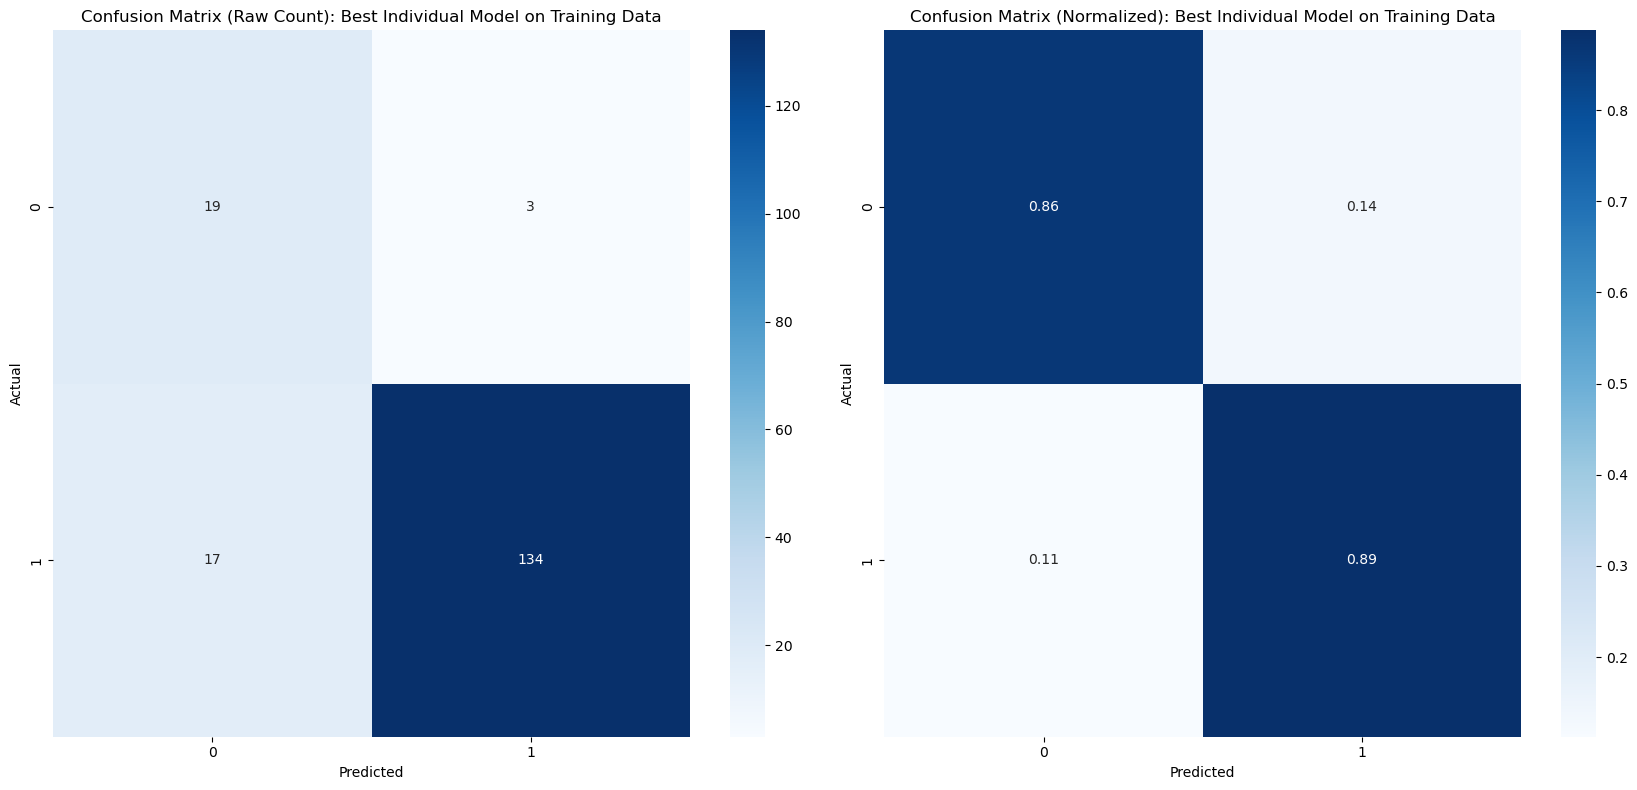

In [124]:
##################################
# Formulating the raw and normalized
# confusion matrices
# from the training data
##################################
cm_raw = confusion_matrix(y_train, individual_unbalanced_class_best_model_original.predict(X_train))
cm_normalized = confusion_matrix(y_train, individual_unbalanced_class_best_model_original.predict(X_train), normalize='true')
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Raw Count): Best Individual Model on Training Data')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized): Best Individual Model on Training Data')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [125]:
##################################
# Summarizing the F1 score results
# and classification metrics
# on the validation data
##################################
print(f"F1 Score on Validation Data: {individual_unbalanced_class_best_model_original_f1_validation:.4f}")
print("\nClassification Report on Validation Data:\n", classification_report(y_validation, individual_unbalanced_class_best_model_original.predict(X_validation)))

F1 Score on Validation Data: 0.9495

Classification Report on Validation Data:
               precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       0.98      0.92      0.95        51

    accuracy                           0.91        58
   macro avg       0.79      0.89      0.83        58
weighted avg       0.93      0.91      0.92        58



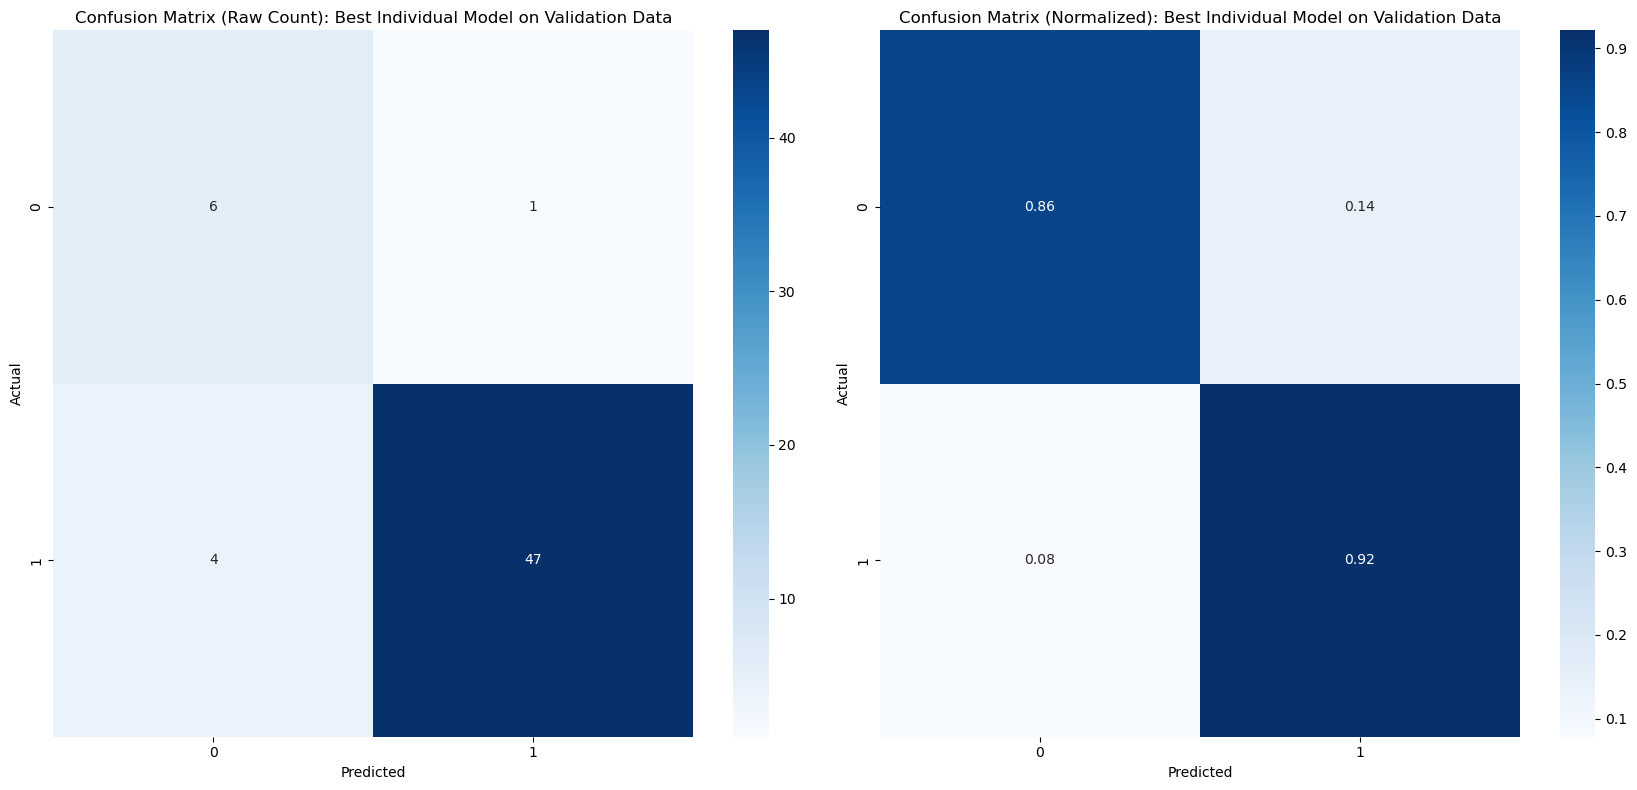

In [126]:
##################################
# Formulating the raw and normalized
# confusion matrices
# from the validation data
##################################
cm_raw = confusion_matrix(y_validation, individual_unbalanced_class_best_model_original.predict(X_validation))
cm_normalized = confusion_matrix(y_validation, individual_unbalanced_class_best_model_original.predict(X_validation), normalize='true')
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Raw Count): Best Individual Model on Validation Data')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized): Best Individual Model on Validation Data')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [127]:
##################################
# Obtaining the logit values (log-odds)
# from the decision function for training data
##################################
individual_unbalanced_class_best_model_original_logit_values = individual_unbalanced_class_best_model_original.decision_function(X_train)

In [128]:
##################################
# Obtaining the estimated probabilities 
# for the positive class (LUNG_CANCER=YES) for training data
##################################
individual_unbalanced_class_best_model_original_probabilities = individual_unbalanced_class_best_model_original.predict_proba(X_train)[:, 1]

In [129]:
##################################
# Sorting the values to generate
# a smoother curve
##################################
individual_unbalanced_class_best_model_original_sorted_indices = np.argsort(individual_unbalanced_class_best_model_original_logit_values)
individual_unbalanced_class_best_model_original_logit_values_sorted = individual_unbalanced_class_best_model_original_logit_values[individual_unbalanced_class_best_model_original_sorted_indices]
individual_unbalanced_class_best_model_original_probabilities_sorted = individual_unbalanced_class_best_model_original_probabilities[individual_unbalanced_class_best_model_original_sorted_indices]

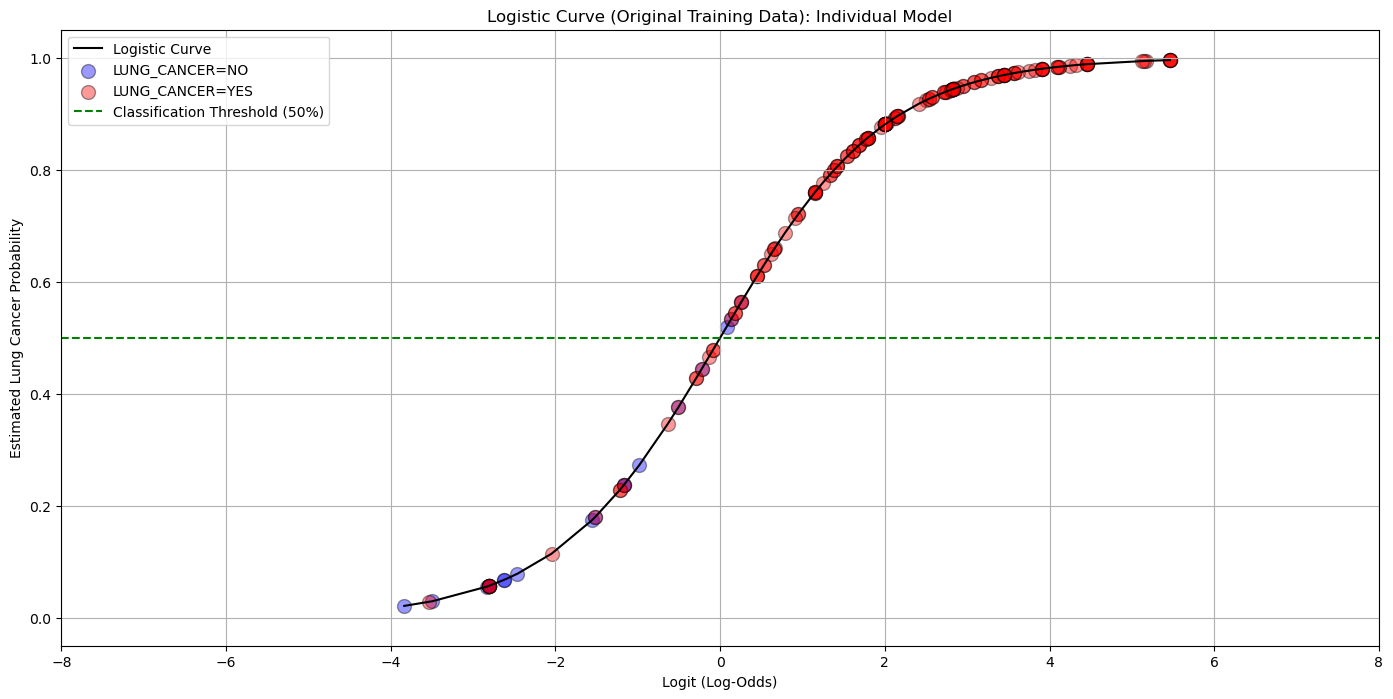

In [130]:
##################################
# Plotting the estimated logistic curve
# using the logit values
# and estimated probabilities
# obtained from the training data
##################################
plt.figure(figsize=(17, 8))
plt.plot(individual_unbalanced_class_best_model_original_logit_values_sorted, 
         individual_unbalanced_class_best_model_original_probabilities_sorted, label='Logistic Curve', color='black')
plt.ylim(-0.05, 1.05)
plt.xlim(-8.00, 8.00)
target_0_indices = y_train == 0
target_1_indices = y_train == 1
plt.scatter(individual_unbalanced_class_best_model_original_logit_values[target_0_indices], 
            individual_unbalanced_class_best_model_original_probabilities[target_0_indices], 
            color='blue', alpha=0.40, s=100, marker= 'o', edgecolor='k', label='LUNG_CANCER=NO')
plt.scatter(individual_unbalanced_class_best_model_original_logit_values[target_1_indices], 
            individual_unbalanced_class_best_model_original_probabilities[target_1_indices], 
            color='red', alpha=0.40, s=100, marker='o', edgecolor='k', label='LUNG_CANCER=YES')
plt.axhline(0.5, color='green', linestyle='--', label='Classification Threshold (50%)')
plt.title('Logistic Curve (Original Training Data): Individual Model')
plt.xlabel('Logit (Log-Odds)')
plt.ylabel('Estimated Lung Cancer Probability')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [131]:
##################################
# Saving the best individual model
# developed from the original training data
################################## 
joblib.dump(individual_unbalanced_class_best_model_original, 
            os.path.join("..", MODELS_PATH, "individual_unbalanced_class_best_model_original.pkl"))

['..\\models\\individual_unbalanced_class_best_model_original.pkl']

#### 1.6.4.2 Stacked Classifier <a class="anchor" id="1.6.4.2"></a>

In [132]:
##################################
# Fitting the model on the 
# original training data
##################################
stacked_unbalanced_class_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('stacked_model',
                                        StackingClassifier(estimators=[('dt',
                                                                        DecisionTreeClassifier(class_weight='balanced',
                                                                                               criterion='entropy',
                                                                                               min_samples_leaf=3,
                                                                                               random_state=88888888)),
                                                                       ('rf',
                                                                        RandomForestClassifier(class_weight='balanced',
                                                                                               criterion='entropy',
                                                                                               min_samples_leaf=3,
                                                                                               random_state=88888888)),
                                                                       ('svm',
                                                                        SVC(class_weight='b...
                                                           final_estimator=LogisticRegression(max_iter=5000,
                                                                                              random_state=88888888,
                                                                                              solver='saga')))]),
             n_jobs=-1,
             param_grid={'stacked_model__dt__max_depth': [3, 5],
                         'stacked_model__final_estimator__class_weight': ['balanced'],
                         'stacked_model__final_estimator__penalty': ['l1', 'l2',
                                                                     None],
                         'stacked_model__rf__max_depth': [3, 5],
                         'stacked_model__svm__kernel': ['linear', 'poly',
                                                        'rbf']},
             scoring='f1', verbose=1)

In [133]:
##################################
# Identifying the best model
##################################
stacked_unbalanced_class_best_model_original = stacked_unbalanced_class_grid_search.best_estimator_

In [134]:
##################################
# Evaluating the F1 scores
# on the training, cross-validation, and validation data
##################################
stacked_unbalanced_class_best_model_original_f1_cv = stacked_unbalanced_class_grid_search.best_score_
stacked_unbalanced_class_best_model_original_f1_train = f1_score(y_train, stacked_unbalanced_class_best_model_original.predict(X_train))
stacked_unbalanced_class_best_model_original_f1_validation = f1_score(y_validation, stacked_unbalanced_class_best_model_original.predict(X_validation))

In [135]:
##################################
# Identifying the optimal model
##################################
print('Best Stacked Model using the Original Train Data: ')
print(f"Best Stacked Model Parameters: {stacked_unbalanced_class_grid_search.best_params_}")

Best Stacked Model using the Original Train Data: 
Best Stacked Model Parameters: {'stacked_model__dt__max_depth': 5, 'stacked_model__final_estimator__class_weight': 'balanced', 'stacked_model__final_estimator__penalty': None, 'stacked_model__rf__max_depth': 5, 'stacked_model__svm__kernel': 'rbf'}


In [136]:
##################################
# Summarizing the F1 score results
# on the training and cross-validated data
# to assess overfitting optimism
##################################
print(f"F1 Score on Cross-Validated Data: {stacked_unbalanced_class_best_model_original_f1_cv:.4f}")
print(f"F1 Score on Training Data: {stacked_unbalanced_class_best_model_original_f1_train:.4f}")
print("\nClassification Report on Training Data:\n", classification_report(y_train, stacked_unbalanced_class_best_model_original.predict(X_train)))

F1 Score on Cross-Validated Data: 0.9085
F1 Score on Training Data: 0.9343

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.54      0.86      0.67        22
           1       0.98      0.89      0.93       151

    accuracy                           0.89       173
   macro avg       0.76      0.88      0.80       173
weighted avg       0.92      0.89      0.90       173



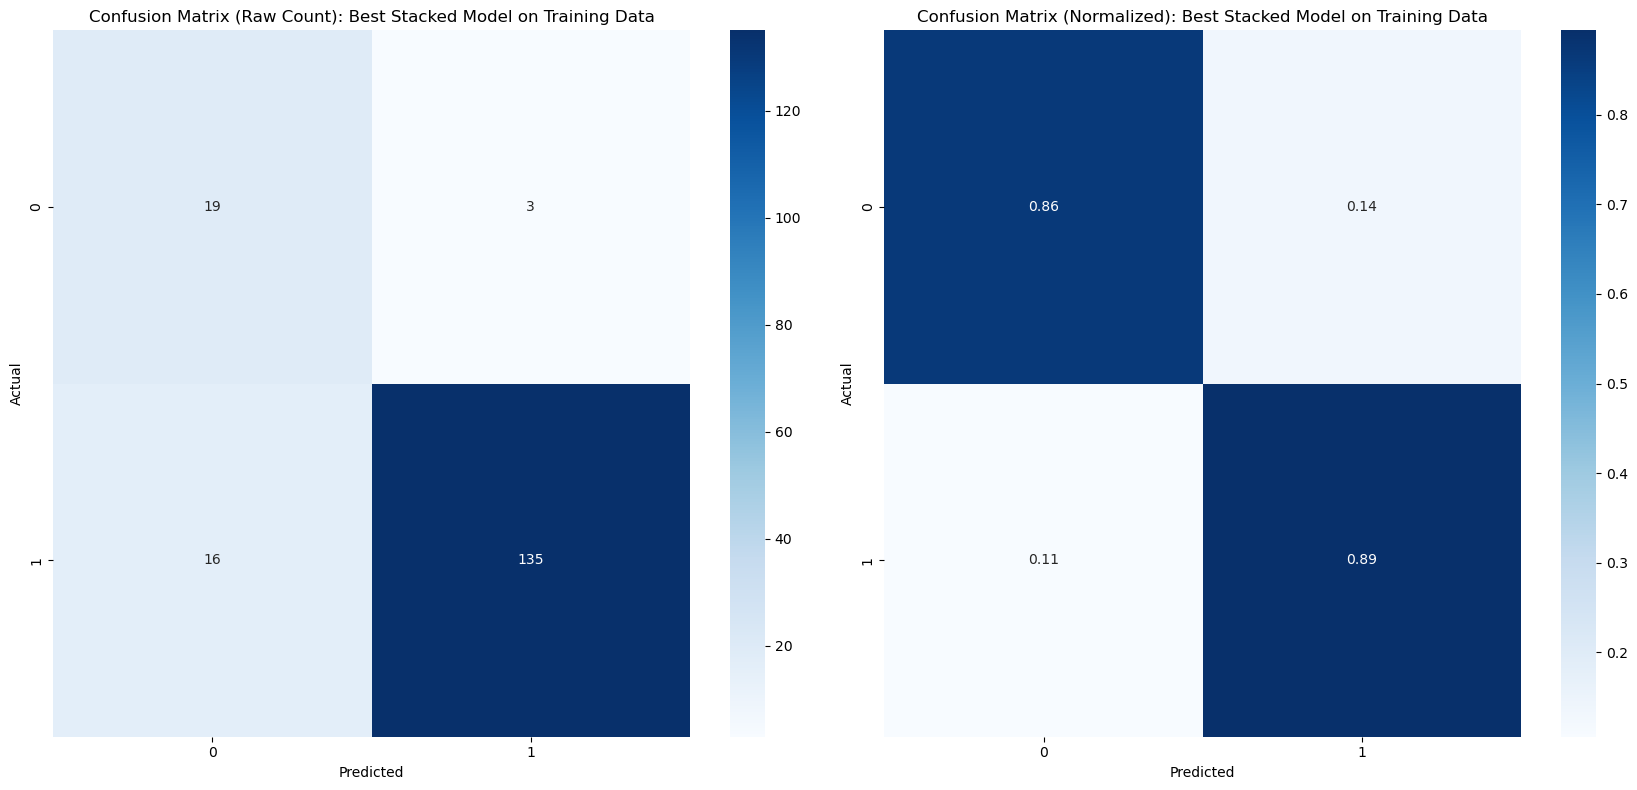

In [137]:
##################################
# Formulating the raw and normalized
# confusion matrices
# from the training data
##################################
cm_raw = confusion_matrix(y_train, stacked_unbalanced_class_best_model_original.predict(X_train))
cm_normalized = confusion_matrix(y_train, stacked_unbalanced_class_best_model_original.predict(X_train), normalize='true')
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Raw Count): Best Stacked Model on Training Data')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized): Best Stacked Model on Training Data')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [138]:
##################################
# Summarizing the F1 score results
# and classification metrics
# on the validation data
##################################
print(f"F1 Score on Validation Data: {stacked_unbalanced_class_best_model_original_f1_validation:.4f}")
print("\nClassification Report on Validation Data:\n", classification_report(y_validation, stacked_unbalanced_class_best_model_original.predict(X_validation)))

F1 Score on Validation Data: 0.9703

Classification Report on Validation Data:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.98      0.96      0.97        51

    accuracy                           0.95        58
   macro avg       0.86      0.91      0.89        58
weighted avg       0.95      0.95      0.95        58



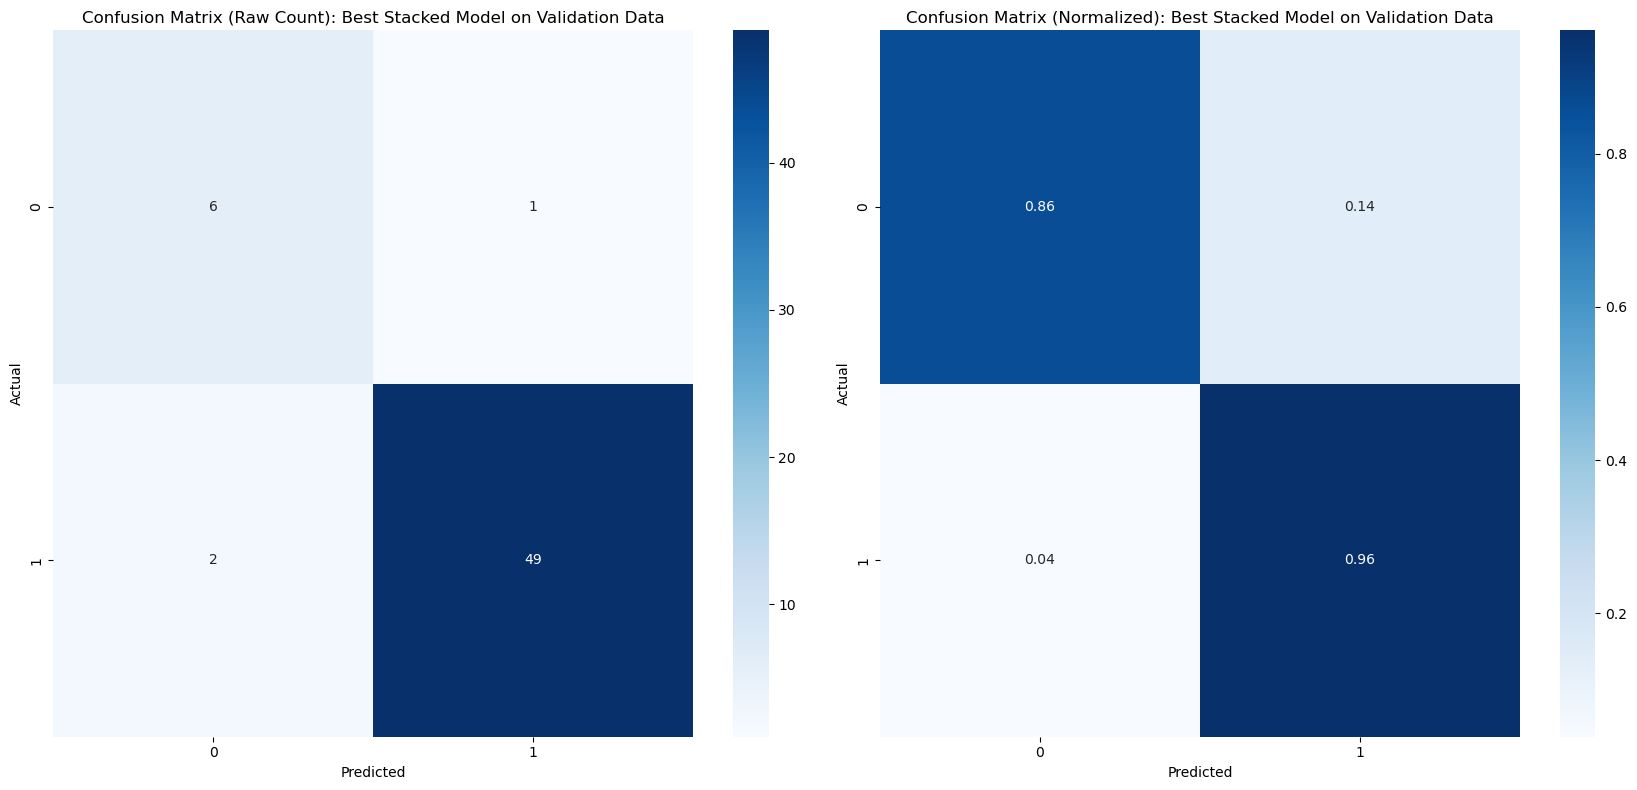

In [139]:
##################################
# Formulating the raw and normalized
# confusion matrices
# from the validation data
##################################
cm_raw = confusion_matrix(y_validation, stacked_unbalanced_class_best_model_original.predict(X_validation))
cm_normalized = confusion_matrix(y_validation, stacked_unbalanced_class_best_model_original.predict(X_validation), normalize='true')
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Raw Count): Best Stacked Model on Validation Data')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized): Best Stacked Model on Validation Data')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [140]:
##################################
# Obtaining the logit values (log-odds)
# from the decision function for training data
##################################
stacked_unbalanced_class_best_model_original_logit_values = stacked_unbalanced_class_best_model_original.decision_function(X_train)

In [141]:
##################################
# Obtaining the estimated probabilities 
# for the positive class (LUNG_CANCER=YES) for training data
##################################
stacked_unbalanced_class_best_model_original_probabilities = stacked_unbalanced_class_best_model_original.predict_proba(X_train)[:, 1]

In [142]:
##################################
# Sorting the values to generate
# a smoother curve
##################################
stacked_unbalanced_class_best_model_original_sorted_indices = np.argsort(stacked_unbalanced_class_best_model_original_logit_values)
stacked_unbalanced_class_best_model_original_logit_values_sorted = stacked_unbalanced_class_best_model_original_logit_values[stacked_unbalanced_class_best_model_original_sorted_indices]
stacked_unbalanced_class_best_model_original_probabilities_sorted = stacked_unbalanced_class_best_model_original_probabilities[stacked_unbalanced_class_best_model_original_sorted_indices]

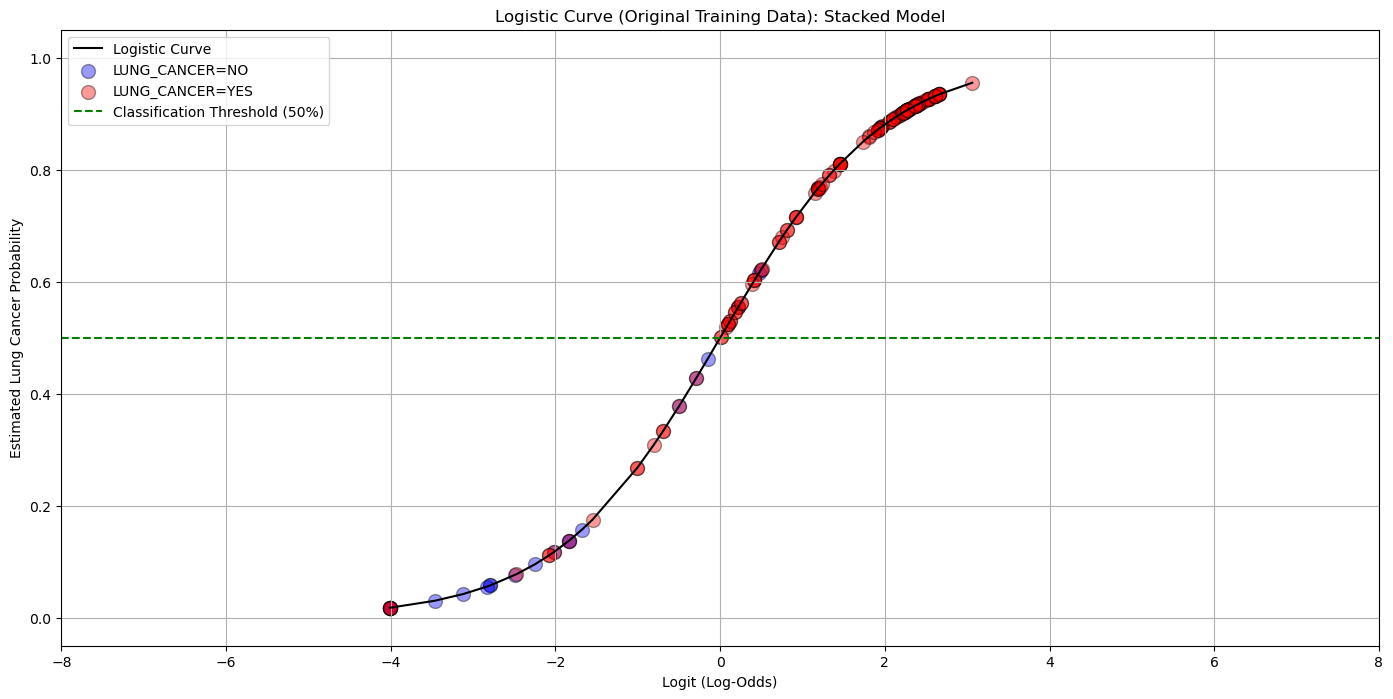

In [143]:
##################################
# Plotting the estimated logistic curve
# using the logit values
# and estimated probabilities
# obtained from the training data
##################################
plt.figure(figsize=(17, 8))
plt.plot(stacked_unbalanced_class_best_model_original_logit_values_sorted, 
         stacked_unbalanced_class_best_model_original_probabilities_sorted, label='Logistic Curve', color='black')
plt.ylim(-0.05, 1.05)
plt.xlim(-8.00, 8.00)
target_0_indices = y_train == 0
target_1_indices = y_train == 1
plt.scatter(stacked_unbalanced_class_best_model_original_logit_values[target_0_indices], 
            stacked_unbalanced_class_best_model_original_probabilities[target_0_indices], 
            color='blue', alpha=0.40, s=100, marker= 'o', edgecolor='k', label='LUNG_CANCER=NO')
plt.scatter(stacked_unbalanced_class_best_model_original_logit_values[target_1_indices], 
            stacked_unbalanced_class_best_model_original_probabilities[target_1_indices], 
            color='red', alpha=0.40, s=100, marker='o', edgecolor='k', label='LUNG_CANCER=YES')
plt.axhline(0.5, color='green', linestyle='--', label='Classification Threshold (50%)')
plt.title('Logistic Curve (Original Training Data): Stacked Model')
plt.xlabel('Logit (Log-Odds)')
plt.ylabel('Estimated Lung Cancer Probability')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [144]:
##################################
# Saving the best stacked model
# developed from the original training data
################################## 
joblib.dump(stacked_unbalanced_class_best_model_original, 
            os.path.join("..", MODELS_PATH, "stacked_unbalanced_class_best_model_original.pkl"))

['..\\models\\stacked_unbalanced_class_best_model_original.pkl']

### 1.6.5 Model Fitting using Upsampled Training Data | Hyperparameter Tuning | Validation <a class="anchor" id="1.6.5"></a>

#### 1.6.5.1 Individual Classifier <a class="anchor" id="1.6.5.1"></a>

In [145]:
##################################
# Fitting the model on the 
# upsampled training data
##################################
individual_balanced_class_grid_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('individual_model',
                                        LogisticRegression(max_iter=5000,
                                                           random_state=88888888,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'individual_model__class_weight': [None],
                         'individual_model__penalty': ['l1', 'l2', None]},
             scoring='f1', verbose=1)

In [146]:
##################################
# Identifying the best model
##################################
individual_balanced_class_best_model_upsampled = individual_balanced_class_grid_search.best_estimator_

In [147]:
##################################
# Evaluating the F1 scores
# on the training, cross-validation, and validation data
##################################
individual_balanced_class_best_model_upsampled_f1_cv = individual_balanced_class_grid_search.best_score_
individual_balanced_class_best_model_upsampled_f1_train_smote = f1_score(y_train_smote, individual_balanced_class_best_model_upsampled.predict(X_train_smote))
individual_balanced_class_best_model_upsampled_f1_validation = f1_score(y_validation, individual_balanced_class_best_model_upsampled.predict(X_validation))

In [148]:
##################################
# Identifying the optimal model
##################################
print('Best Individual Model using the Original Train Data: ')
print(f"Best Individual Model Parameters: {individual_balanced_class_grid_search.best_params_}")

Best Individual Model using the Original Train Data: 
Best Individual Model Parameters: {'individual_model__class_weight': None, 'individual_model__penalty': 'l2'}


In [149]:
##################################
# Summarizing the F1 score results
# on the training and cross-validated data
# to assess overfitting optimism
##################################
print(f"F1 Score on Cross-Validated Data: {individual_balanced_class_best_model_upsampled_f1_cv:.4f}")
print(f"F1 Score on Training Data: {individual_balanced_class_best_model_upsampled_f1_train_smote:.4f}")
print("\nClassification Report on Training Data:\n", classification_report(y_train_smote, individual_balanced_class_best_model_upsampled.predict(X_train_smote)))

F1 Score on Cross-Validated Data: 0.9474
F1 Score on Training Data: 0.9495

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       151
           1       0.97      0.93      0.95       151

    accuracy                           0.95       302
   macro avg       0.95      0.95      0.95       302
weighted avg       0.95      0.95      0.95       302



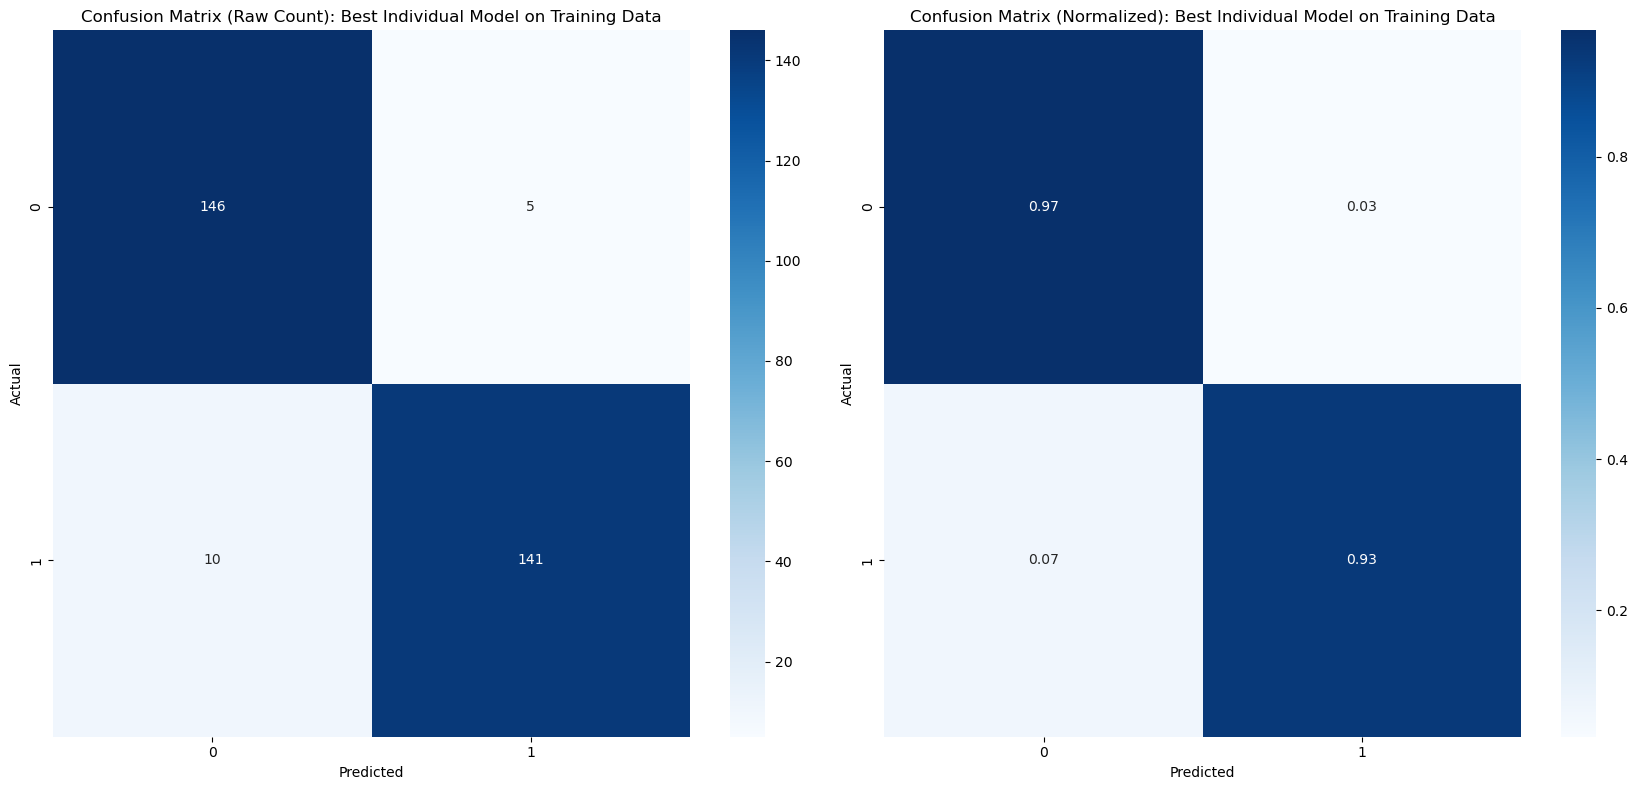

In [150]:
##################################
# Formulating the raw and normalized
# confusion matrices
# from the training data
##################################
cm_raw = confusion_matrix(y_train_smote, individual_balanced_class_best_model_upsampled.predict(X_train_smote))
cm_normalized = confusion_matrix(y_train_smote, individual_balanced_class_best_model_upsampled.predict(X_train_smote), normalize='true')
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Raw Count): Best Individual Model on Training Data')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized): Best Individual Model on Training Data')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [151]:
##################################
# Summarizing the F1 score results
# and classification metrics
# on the validation data
##################################
print(f"F1 Score on Validation Data: {individual_balanced_class_best_model_upsampled_f1_validation:.4f}")
print("\nClassification Report on Validation Data:\n", classification_report(y_validation, individual_balanced_class_best_model_upsampled.predict(X_validation)))

F1 Score on Validation Data: 0.9615

Classification Report on Validation Data:
               precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.94      0.98      0.96        51

    accuracy                           0.93        58
   macro avg       0.87      0.78      0.81        58
weighted avg       0.93      0.93      0.93        58



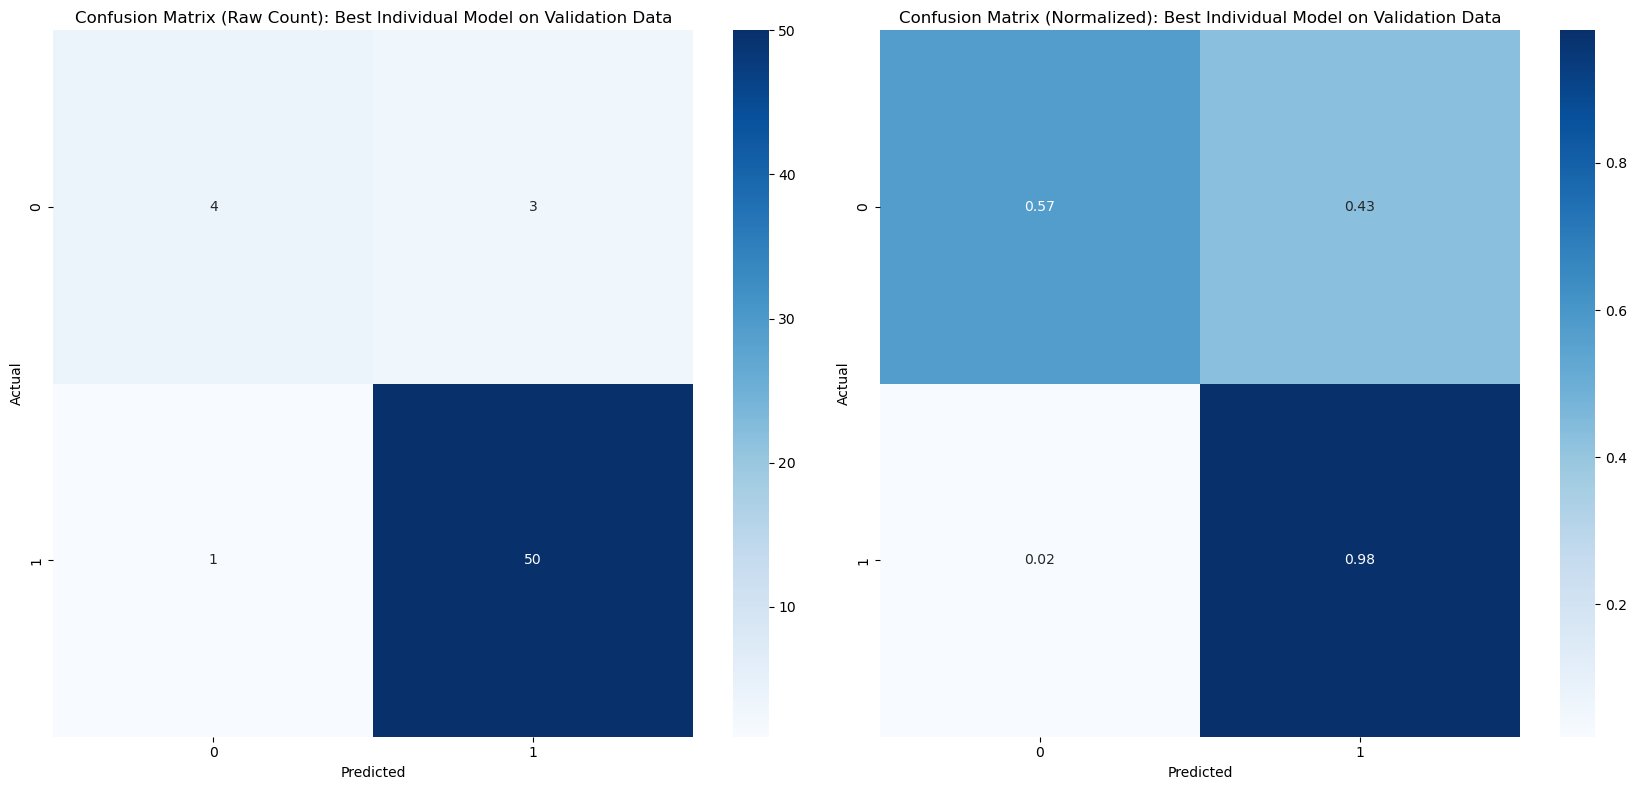

In [152]:
##################################
# Formulating the raw and normalized
# confusion matrices
# from the validation data
##################################
cm_raw = confusion_matrix(y_validation, individual_balanced_class_best_model_upsampled.predict(X_validation))
cm_normalized = confusion_matrix(y_validation, individual_balanced_class_best_model_upsampled.predict(X_validation), normalize='true')
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Raw Count): Best Individual Model on Validation Data')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized): Best Individual Model on Validation Data')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [153]:
##################################
# Obtaining the logit values (log-odds)
# from the decision function for training data
##################################
individual_balanced_class_best_model_upsampled_logit_values = individual_balanced_class_best_model_upsampled.decision_function(X_train_smote)

In [154]:
##################################
# Obtaining the estimated probabilities 
# for the positive class (LUNG_CANCER=YES) for training data
##################################
individual_balanced_class_best_model_upsampled_probabilities = individual_balanced_class_best_model_upsampled.predict_proba(X_train_smote)[:, 1]

In [155]:
##################################
# Sorting the values to generate
# a smoother curve
##################################
individual_balanced_class_best_model_upsampled_sorted_indices = np.argsort(individual_balanced_class_best_model_upsampled_logit_values)
individual_balanced_class_best_model_upsampled_logit_values_sorted = individual_balanced_class_best_model_upsampled_logit_values[individual_balanced_class_best_model_upsampled_sorted_indices]
individual_balanced_class_best_model_upsampled_probabilities_sorted = individual_balanced_class_best_model_upsampled_probabilities[individual_balanced_class_best_model_upsampled_sorted_indices]

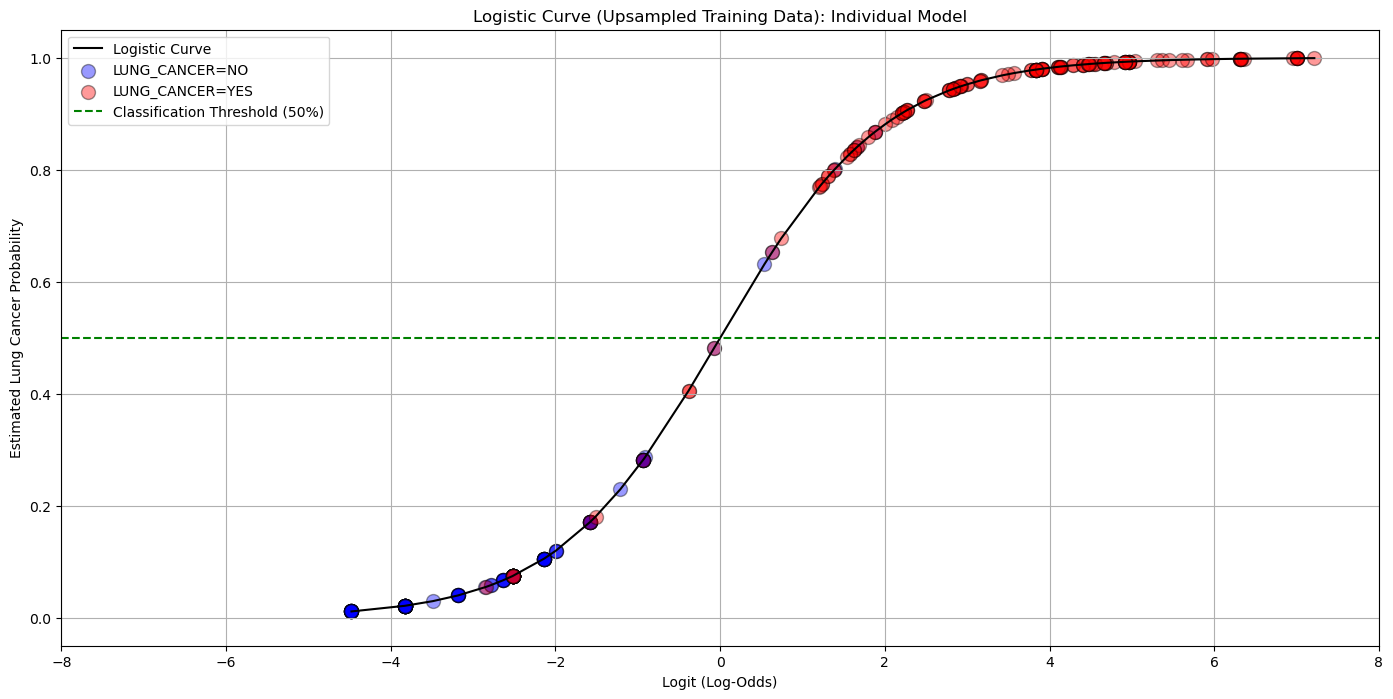

In [156]:
##################################
# Plotting the estimated logistic curve
# using the logit values
# and estimated probabilities
# obtained from the training data
##################################
plt.figure(figsize=(17, 8))
plt.plot(individual_balanced_class_best_model_upsampled_logit_values_sorted, 
         individual_balanced_class_best_model_upsampled_probabilities_sorted, label='Logistic Curve', color='black')
plt.ylim(-0.05, 1.05)
plt.xlim(-8.00, 8.00)
target_0_indices = y_train_smote == 0
target_1_indices = y_train_smote == 1
plt.scatter(individual_balanced_class_best_model_upsampled_logit_values[target_0_indices], 
            individual_balanced_class_best_model_upsampled_probabilities[target_0_indices], 
            color='blue', alpha=0.40, s=100, marker= 'o', edgecolor='k', label='LUNG_CANCER=NO')
plt.scatter(individual_balanced_class_best_model_upsampled_logit_values[target_1_indices], 
            individual_balanced_class_best_model_upsampled_probabilities[target_1_indices], 
            color='red', alpha=0.40, s=100, marker='o', edgecolor='k', label='LUNG_CANCER=YES')
plt.axhline(0.5, color='green', linestyle='--', label='Classification Threshold (50%)')
plt.title('Logistic Curve (Upsampled Training Data): Individual Model')
plt.xlabel('Logit (Log-Odds)')
plt.ylabel('Estimated Lung Cancer Probability')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [157]:
##################################
# Saving the best individual model
# developed from the upsampled training data
################################## 
joblib.dump(individual_balanced_class_best_model_upsampled, 
            os.path.join("..", MODELS_PATH, "individual_balanced_class_best_model_upsampled.pkl"))

['..\\models\\individual_balanced_class_best_model_upsampled.pkl']

#### 1.6.5.2 Stacked Classifier <a class="anchor" id="1.6.5.2"></a>

In [158]:
##################################
# Fitting the model on the 
# upsampled training data
##################################
stacked_balanced_class_grid_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('stacked_model',
                                        StackingClassifier(estimators=[('dt',
                                                                        DecisionTreeClassifier(criterion='entropy',
                                                                                               min_samples_leaf=3,
                                                                                               random_state=88888888)),
                                                                       ('rf',
                                                                        RandomForestClassifier(criterion='entropy',
                                                                                               min_samples_leaf=3,
                                                                                               random_state=88888888)),
                                                                       ('svm',
                                                                        SVC(random_state=88888888))],
                                                           final_estimator=LogisticRegression(max_iter=5000,
                                                                                              random_state=88888888,
                                                                                              solver='saga')))]),
             n_jobs=-1,
             param_grid={'stacked_model__dt__max_depth': [3, 5],
                         'stacked_model__final_estimator__class_weight': [None],
                         'stacked_model__final_estimator__penalty': ['l1', 'l2',
                                                                     None],
                         'stacked_model__rf__max_depth': [3, 5],
                         'stacked_model__svm__kernel': ['linear', 'poly',
                                                        'rbf']},
             scoring='f1', verbose=1)

In [159]:
##################################
# Identifying the best model
##################################
stacked_balanced_class_best_model_upsampled = stacked_balanced_class_grid_search.best_estimator_

In [160]:
##################################
# Evaluating the F1 scores
# on the training, cross-validation, and validation data
##################################
stacked_balanced_class_best_model_upsampled_f1_cv = stacked_balanced_class_grid_search.best_score_
stacked_balanced_class_best_model_upsampled_f1_train_smote = f1_score(y_train_smote, stacked_balanced_class_best_model_upsampled.predict(X_train_smote))
stacked_balanced_class_best_model_upsampled_f1_validation = f1_score(y_validation, stacked_balanced_class_best_model_upsampled.predict(X_validation))

In [161]:
##################################
# Identifying the optimal model
##################################
print('Best Stacked Model using the Upsampled Train Data: ')
print(f"Best Stacked Model Parameters: {stacked_balanced_class_grid_search.best_params_}")

Best Stacked Model using the Upsampled Train Data: 
Best Stacked Model Parameters: {'stacked_model__dt__max_depth': 3, 'stacked_model__final_estimator__class_weight': None, 'stacked_model__final_estimator__penalty': None, 'stacked_model__rf__max_depth': 3, 'stacked_model__svm__kernel': 'rbf'}


In [162]:
##################################
# Summarizing the F1 score results
# on the training and cross-validated data
# to assess overfitting optimism
##################################
print(f"F1 Score on Cross-Validated Data: {stacked_balanced_class_best_model_upsampled_f1_cv:.4f}")
print(f"F1 Score on Training Data: {stacked_balanced_class_best_model_upsampled_f1_train_smote:.4f}")
print("\nClassification Report on Training Data:\n", classification_report(y_train_smote, stacked_balanced_class_best_model_upsampled.predict(X_train_smote)))

F1 Score on Cross-Validated Data: 0.9522
F1 Score on Training Data: 0.9603

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       151
           1       0.96      0.96      0.96       151

    accuracy                           0.96       302
   macro avg       0.96      0.96      0.96       302
weighted avg       0.96      0.96      0.96       302



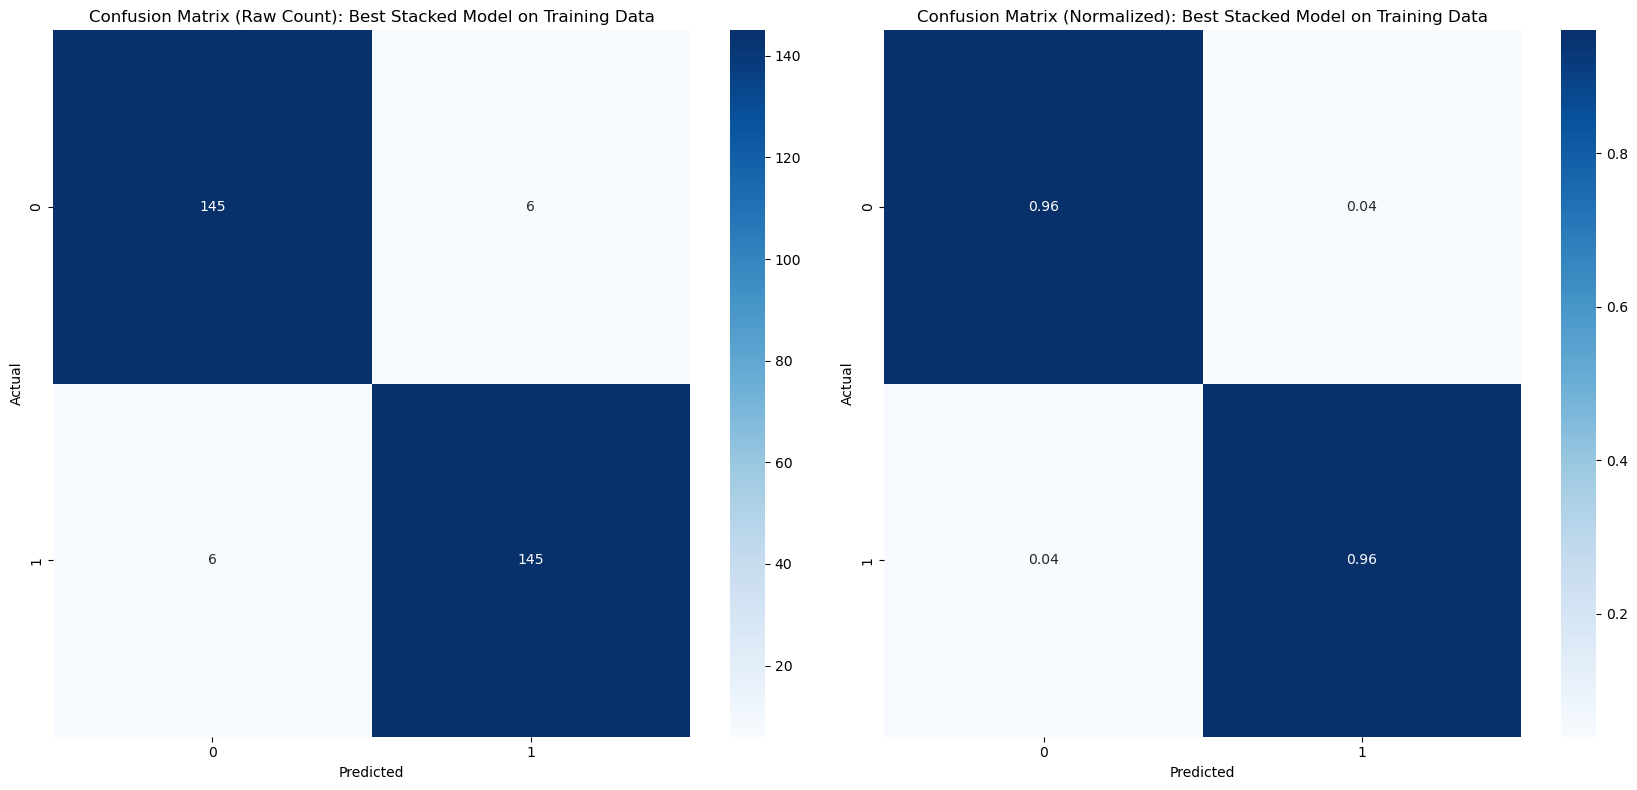

In [163]:
##################################
# Formulating the raw and normalized
# confusion matrices
# from the training data
##################################
cm_raw = confusion_matrix(y_train_smote, stacked_balanced_class_best_model_upsampled.predict(X_train_smote))
cm_normalized = confusion_matrix(y_train_smote, stacked_balanced_class_best_model_upsampled.predict(X_train_smote), normalize='true')
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Raw Count): Best Stacked Model on Training Data')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized): Best Stacked Model on Training Data')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [164]:
##################################
# Summarizing the F1 score results
# and classification metrics
# on the validation data
##################################
print(f"F1 Score on Validation Data: {stacked_balanced_class_best_model_upsampled_f1_validation:.4f}")
print("\nClassification Report on Validation Data:\n", classification_report(y_validation, stacked_balanced_class_best_model_upsampled.predict(X_validation)))

F1 Score on Validation Data: 0.9709

Classification Report on Validation Data:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.96      0.98      0.97        51

    accuracy                           0.95        58
   macro avg       0.90      0.85      0.87        58
weighted avg       0.95      0.95      0.95        58



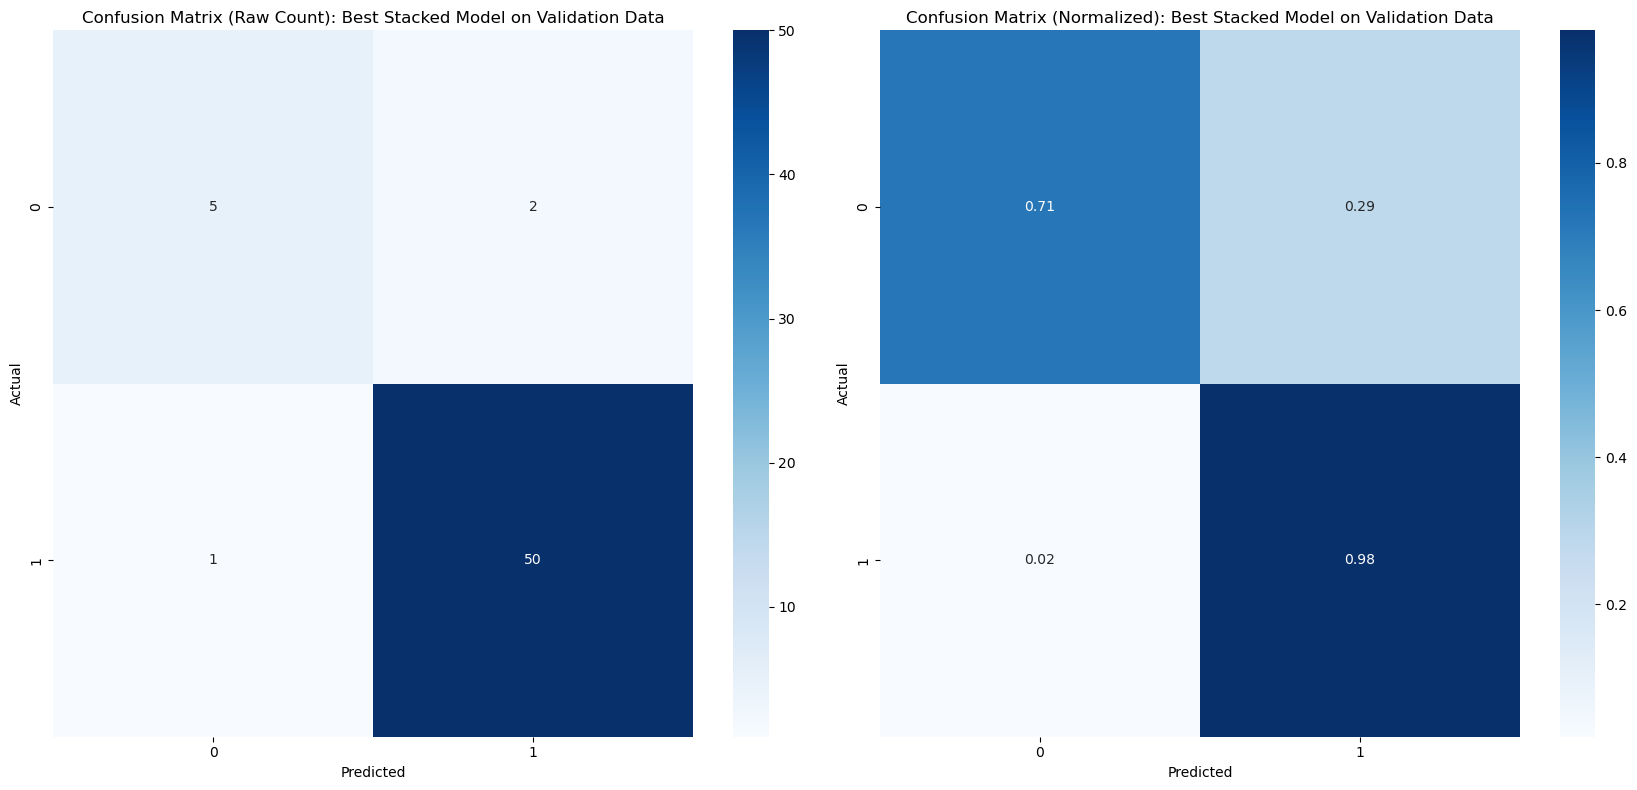

In [165]:
##################################
# Formulating the raw and normalized
# confusion matrices
# from the validation data
##################################
cm_raw = confusion_matrix(y_validation, stacked_balanced_class_best_model_upsampled.predict(X_validation))
cm_normalized = confusion_matrix(y_validation, stacked_balanced_class_best_model_upsampled.predict(X_validation), normalize='true')
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Raw Count): Best Stacked Model on Validation Data')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized): Best Stacked Model on Validation Data')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [166]:
##################################
# Obtaining the logit values (log-odds)
# from the decision function for training data
##################################
stacked_balanced_class_best_model_upsampled_logit_values = stacked_balanced_class_best_model_upsampled.decision_function(X_train_smote)

In [167]:
##################################
# Obtaining the estimated probabilities 
# for the positive class (LUNG_CANCER=YES) for training data
##################################
stacked_balanced_class_best_model_upsampled_probabilities = stacked_balanced_class_best_model_upsampled.predict_proba(X_train_smote)[:, 1]

In [168]:
##################################
# Sorting the values to generate
# a smoother curve
##################################
stacked_balanced_class_best_model_upsampled_sorted_indices = np.argsort(stacked_balanced_class_best_model_upsampled_logit_values)
stacked_balanced_class_best_model_upsampled_logit_values_sorted = stacked_balanced_class_best_model_upsampled_logit_values[stacked_balanced_class_best_model_upsampled_sorted_indices]
stacked_balanced_class_best_model_upsampled_probabilities_sorted = stacked_balanced_class_best_model_upsampled_probabilities[stacked_balanced_class_best_model_upsampled_sorted_indices]

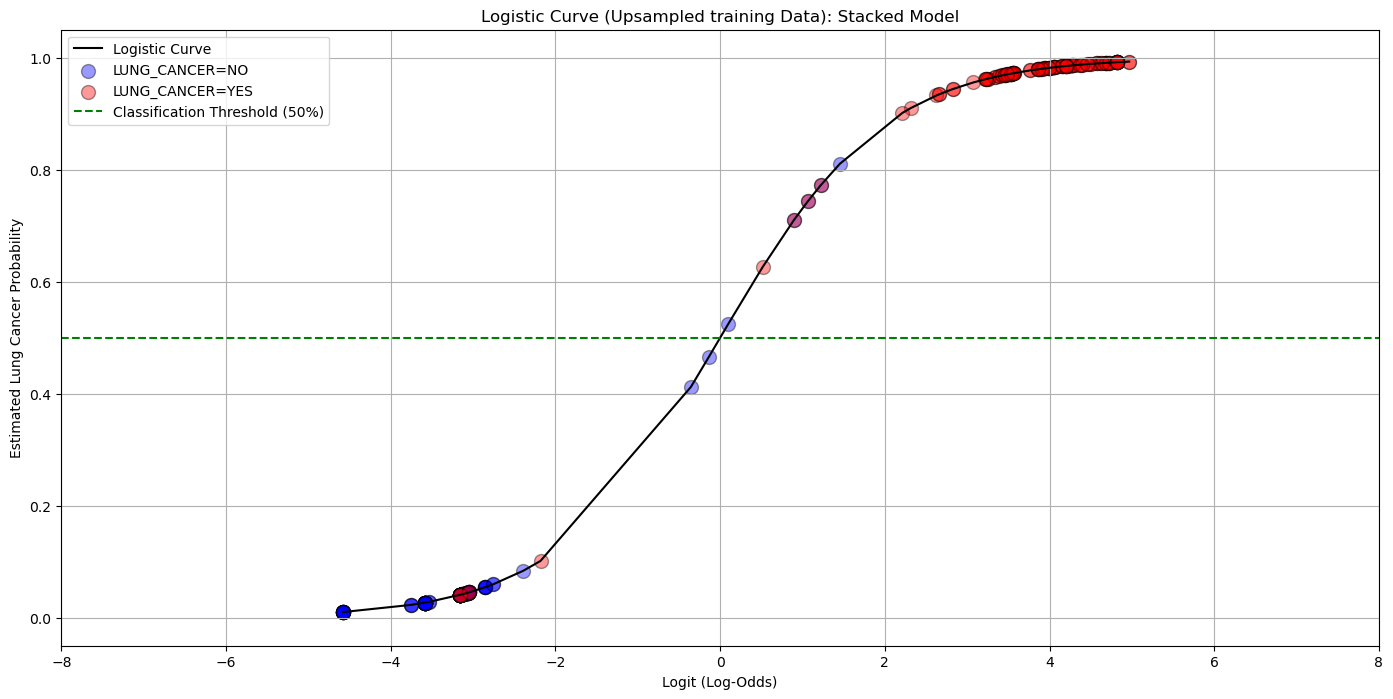

In [169]:
##################################
# Plotting the estimated logistic curve
# using the logit values
# and estimated probabilities
# obtained from the training data
##################################
plt.figure(figsize=(17, 8))
plt.plot(stacked_balanced_class_best_model_upsampled_logit_values_sorted, 
         stacked_balanced_class_best_model_upsampled_probabilities_sorted, label='Logistic Curve', color='black')
plt.ylim(-0.05, 1.05)
plt.xlim(-8.00, 8.00)
target_0_indices = y_train_smote == 0
target_1_indices = y_train_smote == 1
plt.scatter(stacked_balanced_class_best_model_upsampled_logit_values[target_0_indices], 
            stacked_balanced_class_best_model_upsampled_probabilities[target_0_indices], 
            color='blue', alpha=0.40, s=100, marker= 'o', edgecolor='k', label='LUNG_CANCER=NO')
plt.scatter(stacked_balanced_class_best_model_upsampled_logit_values[target_1_indices], 
            stacked_balanced_class_best_model_upsampled_probabilities[target_1_indices], 
            color='red', alpha=0.40, s=100, marker='o', edgecolor='k', label='LUNG_CANCER=YES')
plt.axhline(0.5, color='green', linestyle='--', label='Classification Threshold (50%)')
plt.title('Logistic Curve (Upsampled training Data): Stacked Model')
plt.xlabel('Logit (Log-Odds)')
plt.ylabel('Estimated Lung Cancer Probability')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [170]:
##################################
# Saving the best stacked model
# developed from the upsampled training data
################################## 
joblib.dump(stacked_balanced_class_best_model_upsampled, 
            os.path.join("..", MODELS_PATH, "stacked_balanced_class_best_model_upsampled.pkl"))

['..\\models\\stacked_balanced_class_best_model_upsampled.pkl']

### 1.6.6 Model Fitting using Downsampled Training Data | Hyperparameter Tuning | Validation <a class="anchor" id="1.6.5"></a>

#### 1.6.6.1 Individual Classifier <a class="anchor" id="1.6.6.1"></a>

In [171]:
##################################
# Fitting the model on the 
# downsampled training data
##################################
individual_unbalanced_class_grid_search.fit(X_train_cnn, y_train_cnn)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('individual_model',
                                        LogisticRegression(max_iter=5000,
                                                           random_state=88888888,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'individual_model__class_weight': ['balanced'],
                         'individual_model__penalty': ['l1', 'l2', None]},
             scoring='f1', verbose=1)

In [172]:
##################################
# Identifying the best model
##################################
individual_unbalanced_class_best_model_downsampled = individual_unbalanced_class_grid_search.best_estimator_

In [173]:
##################################
# Evaluating the F1 scores
# on the training, cross-validation, and validation data
##################################
individual_unbalanced_class_best_model_downsampled_f1_cv = individual_unbalanced_class_grid_search.best_score_
individual_unbalanced_class_best_model_downsampled_f1_train_cnn = f1_score(y_train_cnn, individual_unbalanced_class_best_model_downsampled.predict(X_train_cnn))
individual_unbalanced_class_best_model_downsampled_f1_validation = f1_score(y_validation, individual_unbalanced_class_best_model_downsampled.predict(X_validation))

In [174]:
##################################
# Identifying the optimal model
##################################
print('Best Individual Model using the Original Train Data: ')
print(f"Best Individual Model Parameters: {individual_unbalanced_class_grid_search.best_params_}")

Best Individual Model using the Original Train Data: 
Best Individual Model Parameters: {'individual_model__class_weight': 'balanced', 'individual_model__penalty': 'l2'}


In [175]:
##################################
# Summarizing the F1 score results
# on the training and cross-validated data
# to assess overfitting optimism
##################################
print(f"F1 Score on Cross-Validated Data: {individual_unbalanced_class_best_model_downsampled_f1_cv:.4f}")
print(f"F1 Score on Training Data: {individual_unbalanced_class_best_model_downsampled_f1_train_cnn:.4f}")
print("\nClassification Report on Training Data:\n", classification_report(y_train_cnn, individual_unbalanced_class_best_model_downsampled.predict(X_train_cnn)))

F1 Score on Cross-Validated Data: 0.7537
F1 Score on Training Data: 0.8533

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.72      0.82      0.77        22
           1       0.89      0.82      0.85        39

    accuracy                           0.82        61
   macro avg       0.80      0.82      0.81        61
weighted avg       0.83      0.82      0.82        61



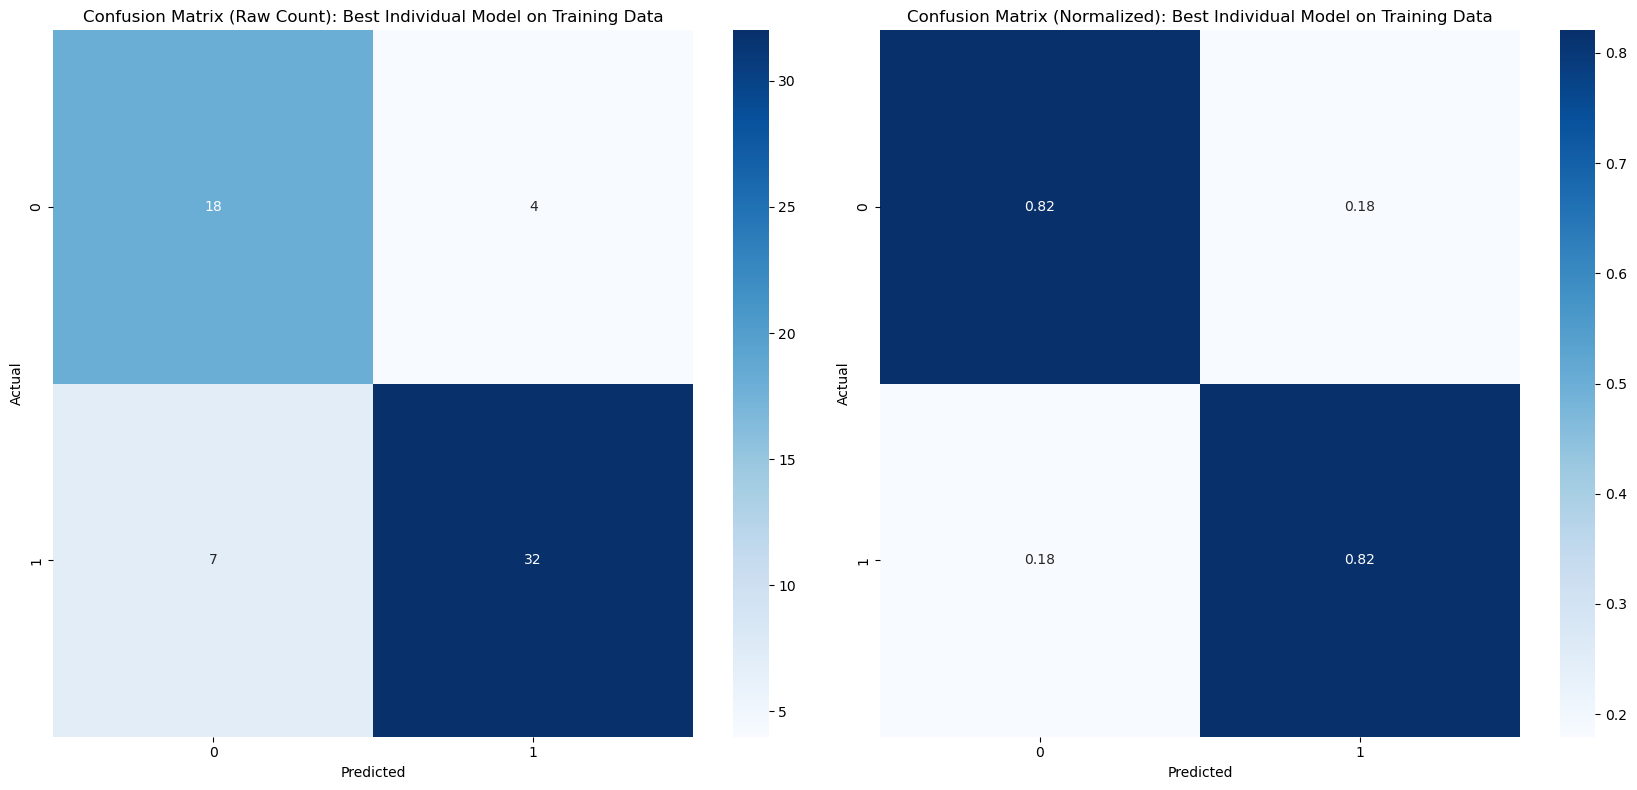

In [176]:
##################################
# Formulating the raw and normalized
# confusion matrices
# from the training data
##################################
cm_raw = confusion_matrix(y_train_cnn, individual_unbalanced_class_best_model_downsampled.predict(X_train_cnn))
cm_normalized = confusion_matrix(y_train_cnn, individual_unbalanced_class_best_model_downsampled.predict(X_train_cnn), normalize='true')
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Raw Count): Best Individual Model on Training Data')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized): Best Individual Model on Training Data')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [177]:
##################################
# Summarizing the F1 score results
# and classification metrics
# on the validation data
##################################
print(f"F1 Score on Validation Data: {individual_unbalanced_class_best_model_downsampled_f1_validation:.4f}")
print("\nClassification Report on Validation Data:\n", classification_report(y_validation, individual_unbalanced_class_best_model_downsampled.predict(X_validation)))

F1 Score on Validation Data: 0.9709

Classification Report on Validation Data:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.96      0.98      0.97        51

    accuracy                           0.95        58
   macro avg       0.90      0.85      0.87        58
weighted avg       0.95      0.95      0.95        58



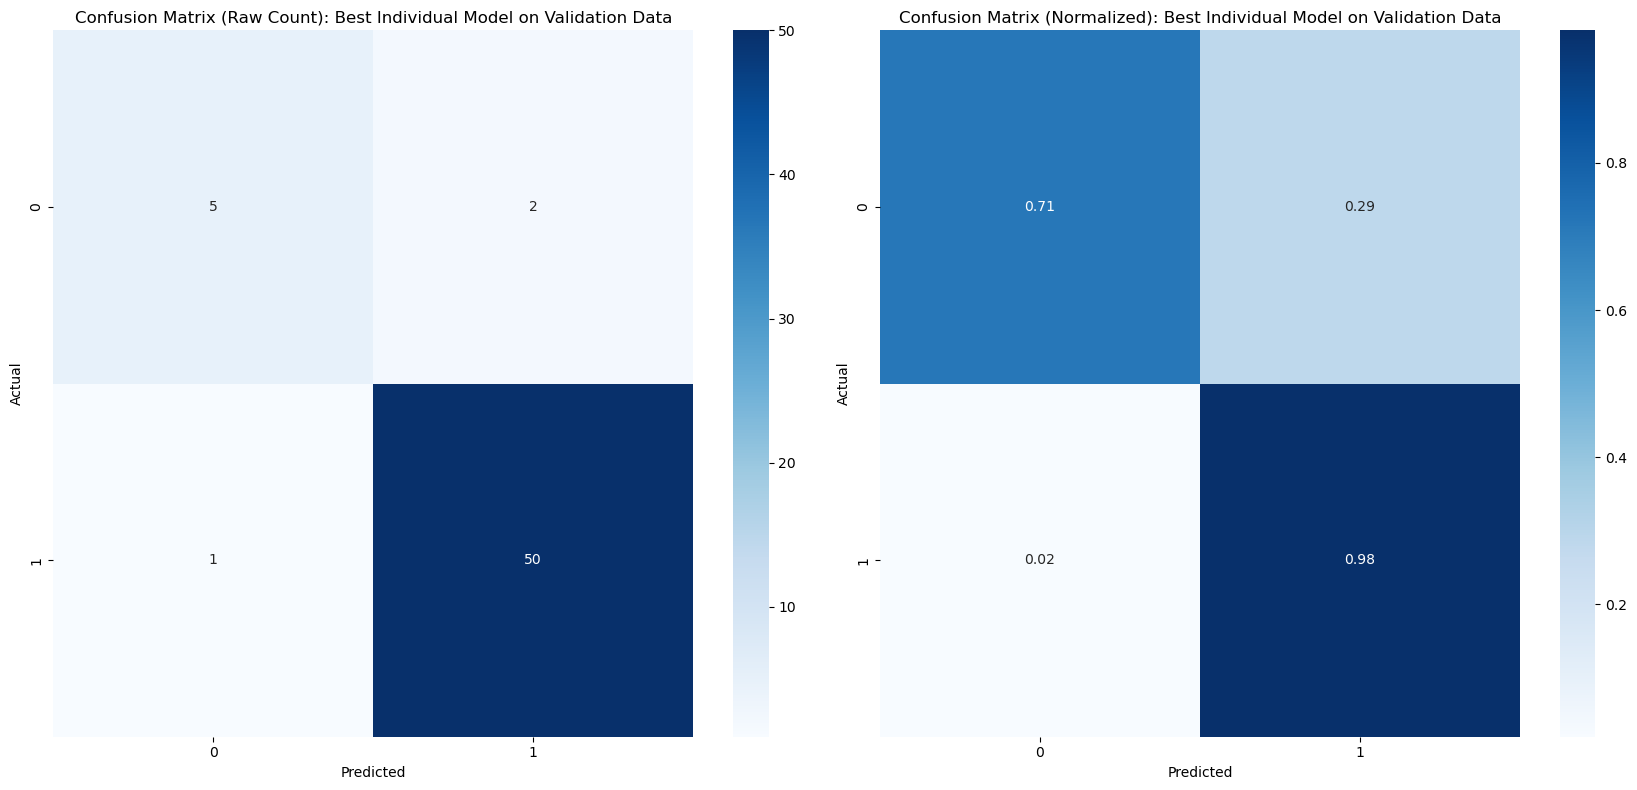

In [178]:
##################################
# Formulating the raw and normalized
# confusion matrices
# from the validation data
##################################
cm_raw = confusion_matrix(y_validation, individual_unbalanced_class_best_model_downsampled.predict(X_validation))
cm_normalized = confusion_matrix(y_validation, individual_unbalanced_class_best_model_downsampled.predict(X_validation), normalize='true')
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Raw Count): Best Individual Model on Validation Data')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized): Best Individual Model on Validation Data')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [179]:
##################################
# Obtaining the logit values (log-odds)
# from the decision function for training data
##################################
individual_unbalanced_class_best_model_downsampled_logit_values = individual_unbalanced_class_best_model_downsampled.decision_function(X_train_cnn)

In [180]:
##################################
# Obtaining the estimated probabilities 
# for the positive class (LUNG_CANCER=YES) for training data
##################################
individual_unbalanced_class_best_model_downsampled_probabilities = individual_unbalanced_class_best_model_downsampled.predict_proba(X_train_cnn)[:, 1]

In [181]:
##################################
# Sorting the values to generate
# a smoother curve
##################################
individual_unbalanced_class_best_model_downsampled_sorted_indices = np.argsort(individual_unbalanced_class_best_model_downsampled_logit_values)
individual_unbalanced_class_best_model_downsampled_logit_values_sorted = individual_unbalanced_class_best_model_downsampled_logit_values[individual_unbalanced_class_best_model_downsampled_sorted_indices]
individual_unbalanced_class_best_model_downsampled_probabilities_sorted = individual_unbalanced_class_best_model_downsampled_probabilities[individual_unbalanced_class_best_model_downsampled_sorted_indices]

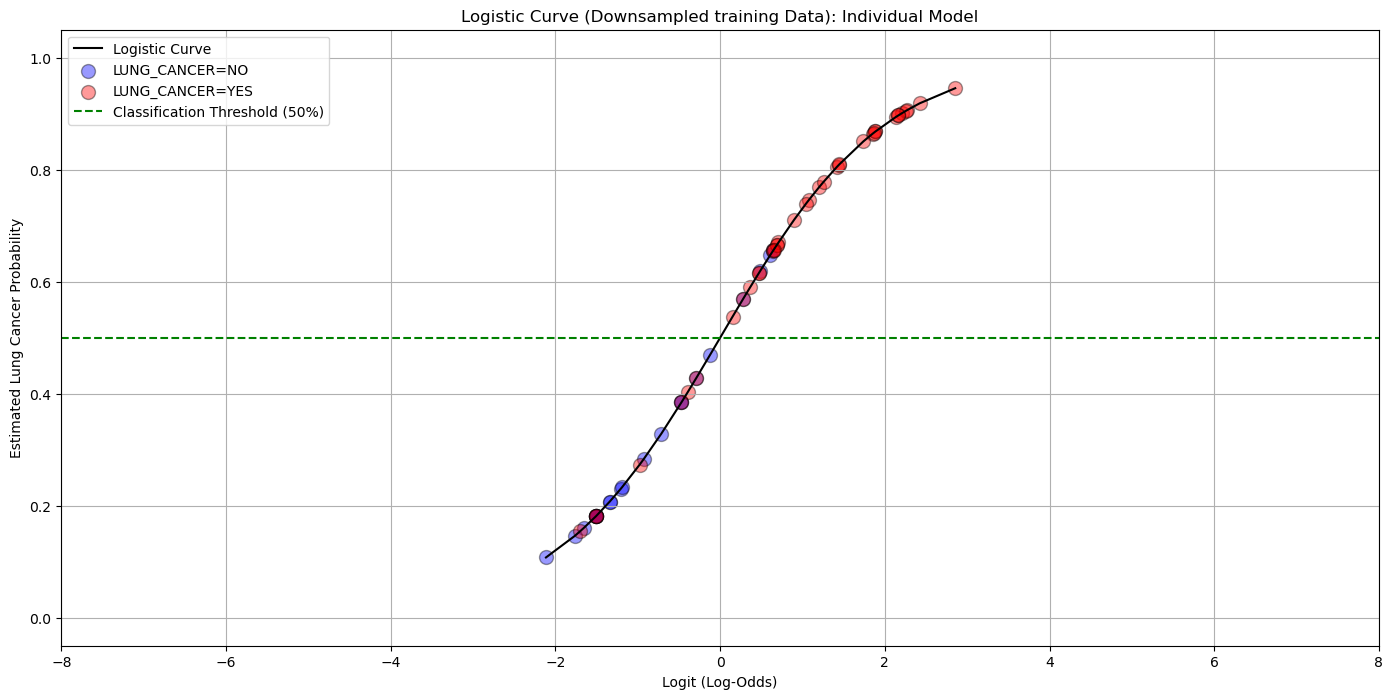

In [182]:
##################################
# Plotting the estimated logistic curve
# using the logit values
# and estimated probabilities
# obtained from the training data
##################################
plt.figure(figsize=(17, 8))
plt.plot(individual_unbalanced_class_best_model_downsampled_logit_values_sorted, 
         individual_unbalanced_class_best_model_downsampled_probabilities_sorted, label='Logistic Curve', color='black')
plt.ylim(-0.05, 1.05)
plt.xlim(-8.00, 8.00)
target_0_indices = y_train_cnn == 0
target_1_indices = y_train_cnn == 1
plt.scatter(individual_unbalanced_class_best_model_downsampled_logit_values[target_0_indices], 
            individual_unbalanced_class_best_model_downsampled_probabilities[target_0_indices], 
            color='blue', alpha=0.40, s=100, marker= 'o', edgecolor='k', label='LUNG_CANCER=NO')
plt.scatter(individual_unbalanced_class_best_model_downsampled_logit_values[target_1_indices], 
            individual_unbalanced_class_best_model_downsampled_probabilities[target_1_indices], 
            color='red', alpha=0.40, s=100, marker='o', edgecolor='k', label='LUNG_CANCER=YES')
plt.axhline(0.5, color='green', linestyle='--', label='Classification Threshold (50%)')
plt.title('Logistic Curve (Downsampled training Data): Individual Model')
plt.xlabel('Logit (Log-Odds)')
plt.ylabel('Estimated Lung Cancer Probability')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [183]:
##################################
# Saving the best individual model
# developed from the downsampled training data
################################## 
joblib.dump(individual_unbalanced_class_best_model_downsampled, 
            os.path.join("..", MODELS_PATH, "individual_unbalanced_class_best_model_downsampled.pkl"))

['..\\models\\individual_unbalanced_class_best_model_downsampled.pkl']

#### 1.6.6.2 Stacked Classifier <a class="anchor" id="1.6.6.2"></a>

In [184]:
##################################
# Fitting the model on the 
# downsampled training data
##################################
stacked_unbalanced_class_grid_search.fit(X_train_cnn, y_train_cnn)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('stacked_model',
                                        StackingClassifier(estimators=[('dt',
                                                                        DecisionTreeClassifier(class_weight='balanced',
                                                                                               criterion='entropy',
                                                                                               min_samples_leaf=3,
                                                                                               random_state=88888888)),
                                                                       ('rf',
                                                                        RandomForestClassifier(class_weight='balanced',
                                                                                               criterion='entropy',
                                                                                               min_samples_leaf=3,
                                                                                               random_state=88888888)),
                                                                       ('svm',
                                                                        SVC(class_weight='b...
                                                           final_estimator=LogisticRegression(max_iter=5000,
                                                                                              random_state=88888888,
                                                                                              solver='saga')))]),
             n_jobs=-1,
             param_grid={'stacked_model__dt__max_depth': [3, 5],
                         'stacked_model__final_estimator__class_weight': ['balanced'],
                         'stacked_model__final_estimator__penalty': ['l1', 'l2',
                                                                     None],
                         'stacked_model__rf__max_depth': [3, 5],
                         'stacked_model__svm__kernel': ['linear', 'poly',
                                                        'rbf']},
             scoring='f1', verbose=1)

In [185]:
##################################
# Identifying the best model
##################################
stacked_unbalanced_class_best_model_downsampled = stacked_unbalanced_class_grid_search.best_estimator_

In [186]:
##################################
# Evaluating the F1 scores
# on the training, cross-validation, and validation data
##################################
stacked_unbalanced_class_best_model_downsampled_f1_cv = stacked_unbalanced_class_grid_search.best_score_
stacked_unbalanced_class_best_model_downsampled_f1_train_cnn = f1_score(y_train_cnn, stacked_unbalanced_class_best_model_downsampled.predict(X_train_cnn))
stacked_unbalanced_class_best_model_downsampled_f1_validation = f1_score(y_validation, stacked_unbalanced_class_best_model_downsampled.predict(X_validation))

In [187]:
##################################
# Evaluating the F1 scores
# on the training, cross-validation, and validation data
##################################
stacked_unbalanced_class_best_model_downsampled_f1_cv = stacked_unbalanced_class_grid_search.best_score_
stacked_unbalanced_class_best_model_downsampled_f1_train_cnn = f1_score(y_train_cnn, stacked_unbalanced_class_best_model_downsampled.predict(X_train_cnn))
stacked_unbalanced_class_best_model_downsampled_f1_validation = f1_score(y_validation, stacked_unbalanced_class_best_model_downsampled.predict(X_validation))

In [188]:
##################################
# Identifying the optimal model
##################################
print('Best Stacked Model using the Downsampled Train Data: ')
print(f"Best Stacked Model Parameters: {stacked_unbalanced_class_grid_search.best_params_}")

Best Stacked Model using the Downsampled Train Data: 
Best Stacked Model Parameters: {'stacked_model__dt__max_depth': 3, 'stacked_model__final_estimator__class_weight': 'balanced', 'stacked_model__final_estimator__penalty': 'l1', 'stacked_model__rf__max_depth': 3, 'stacked_model__svm__kernel': 'rbf'}


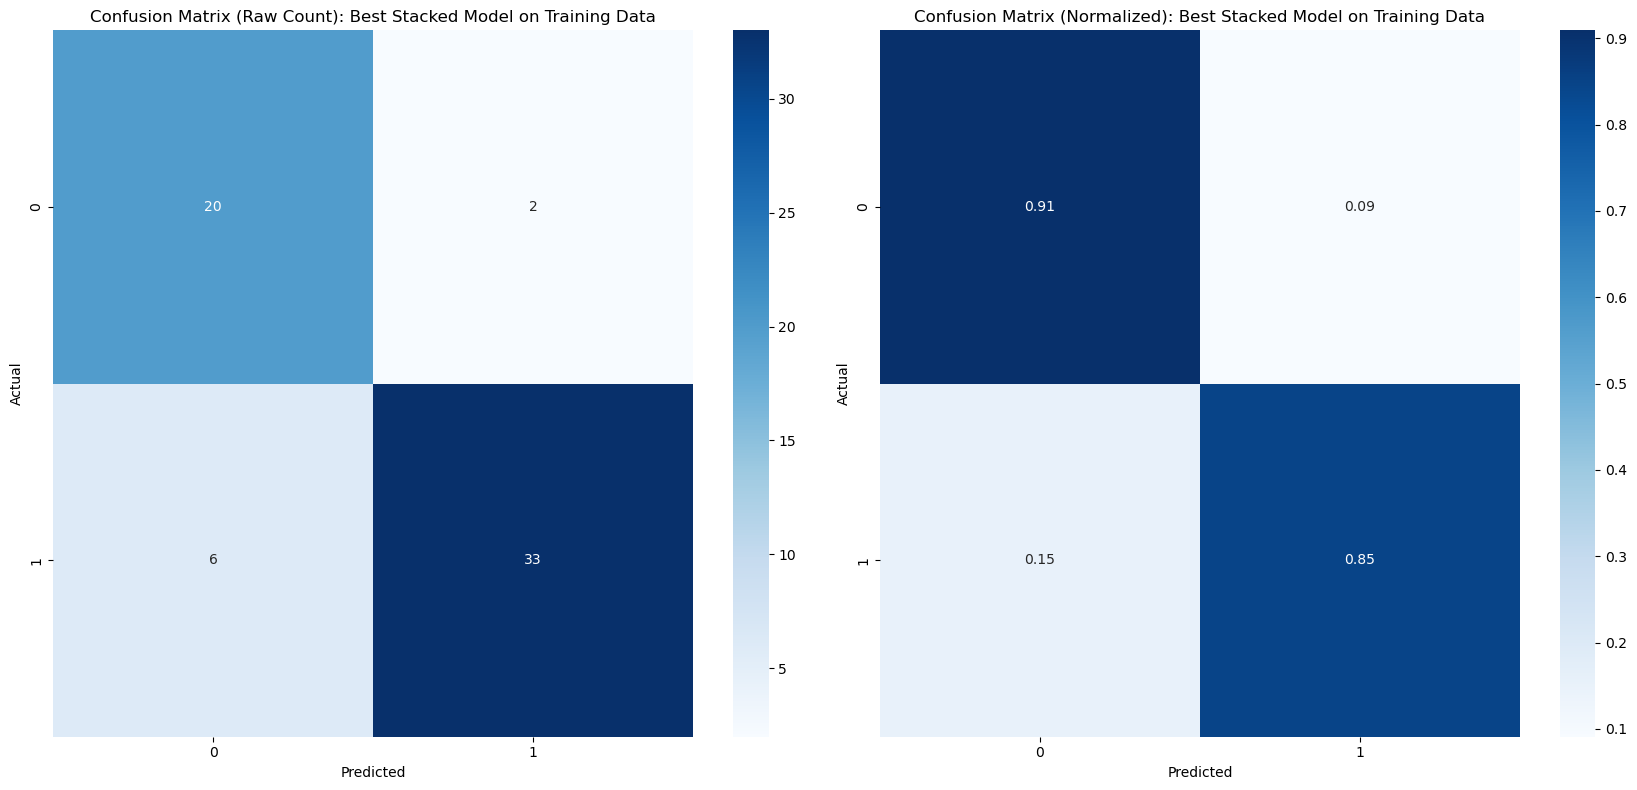

In [189]:
##################################
# Formulating the raw and normalized
# confusion matrices
# from the training data
##################################
cm_raw = confusion_matrix(y_train_cnn, stacked_unbalanced_class_best_model_downsampled.predict(X_train_cnn))
cm_normalized = confusion_matrix(y_train_cnn, stacked_unbalanced_class_best_model_downsampled.predict(X_train_cnn), normalize='true')
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Raw Count): Best Stacked Model on Training Data')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized): Best Stacked Model on Training Data')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [190]:
##################################
# Summarizing the F1 score results
# and classification metrics
# on the validation data
##################################
print(f"F1 Score on Validation Data: {stacked_unbalanced_class_best_model_downsampled_f1_validation:.4f}")
print("\nClassification Report on Validation Data:\n", classification_report(y_validation, stacked_unbalanced_class_best_model_downsampled.predict(X_validation)))

F1 Score on Validation Data: 0.9505

Classification Report on Validation Data:
               precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.96      0.94      0.95        51

    accuracy                           0.91        58
   macro avg       0.79      0.83      0.81        58
weighted avg       0.92      0.91      0.92        58



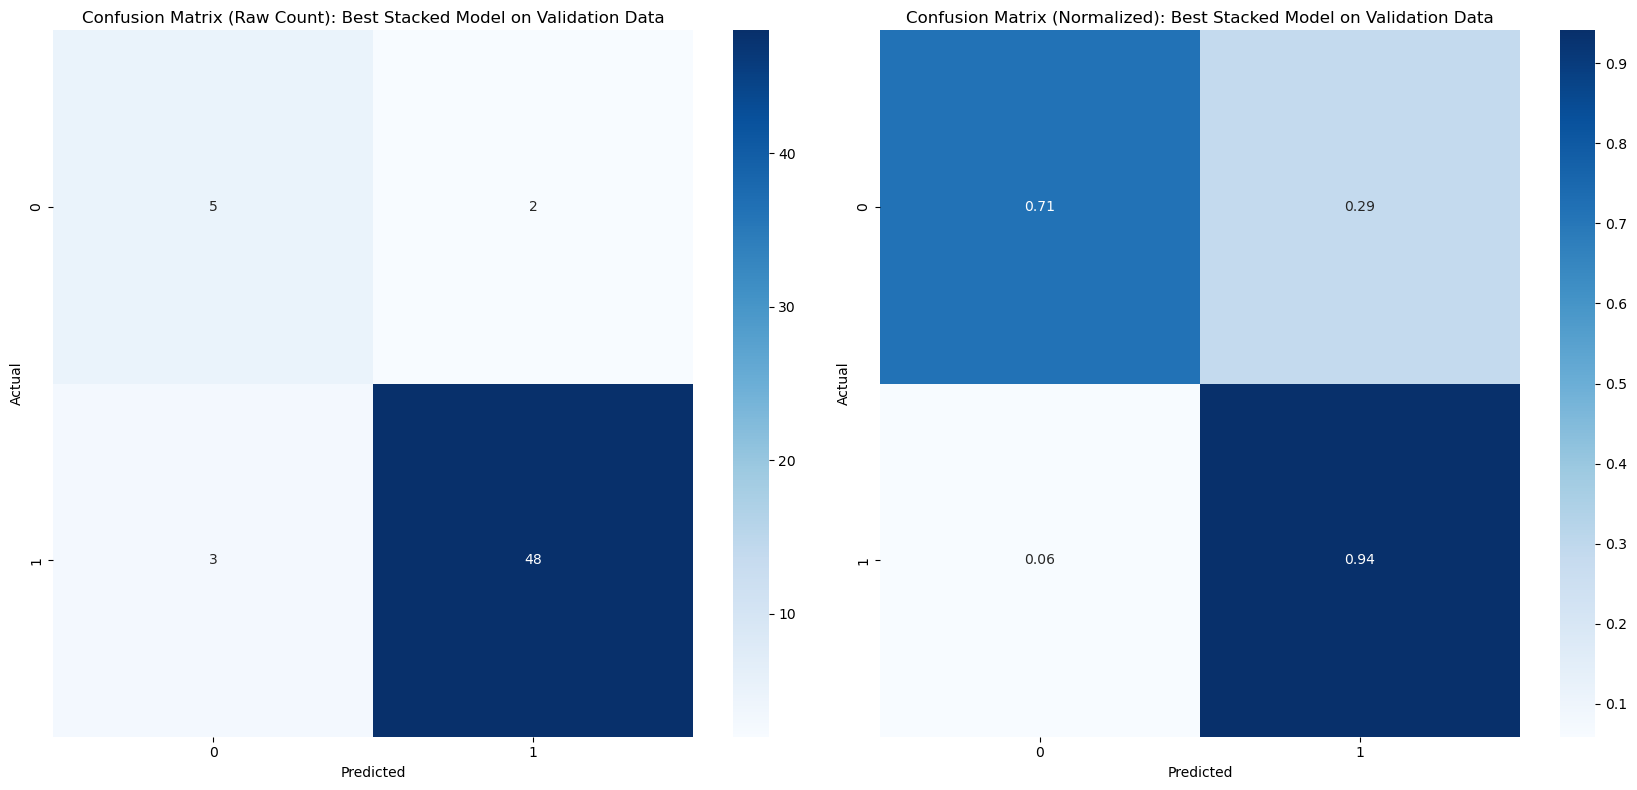

In [191]:
##################################
# Formulating the raw and normalized
# confusion matrices
# from the validation data
##################################
cm_raw = confusion_matrix(y_validation, stacked_unbalanced_class_best_model_downsampled.predict(X_validation))
cm_normalized = confusion_matrix(y_validation, stacked_unbalanced_class_best_model_downsampled.predict(X_validation), normalize='true')
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Raw Count): Best Stacked Model on Validation Data')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized): Best Stacked Model on Validation Data')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [192]:
##################################
# Obtaining the logit values (log-odds)
# from the decision function for training data
##################################
stacked_unbalanced_class_best_model_downsampled_logit_values = stacked_unbalanced_class_best_model_downsampled.decision_function(X_train_cnn)

In [193]:
##################################
# Obtaining the estimated probabilities 
# for the positive class (LUNG_CANCER=YES) for training data
##################################
stacked_unbalanced_class_best_model_downsampled_probabilities = stacked_unbalanced_class_best_model_downsampled.predict_proba(X_train_cnn)[:, 1]

In [194]:
##################################
# Sorting the values to generate
# a smoother curve
##################################
stacked_unbalanced_class_best_model_downsampled_sorted_indices = np.argsort(stacked_unbalanced_class_best_model_downsampled_logit_values)
stacked_unbalanced_class_best_model_downsampled_logit_values_sorted = stacked_unbalanced_class_best_model_downsampled_logit_values[stacked_unbalanced_class_best_model_downsampled_sorted_indices]
stacked_unbalanced_class_best_model_downsampled_probabilities_sorted = stacked_unbalanced_class_best_model_downsampled_probabilities[stacked_unbalanced_class_best_model_downsampled_sorted_indices]

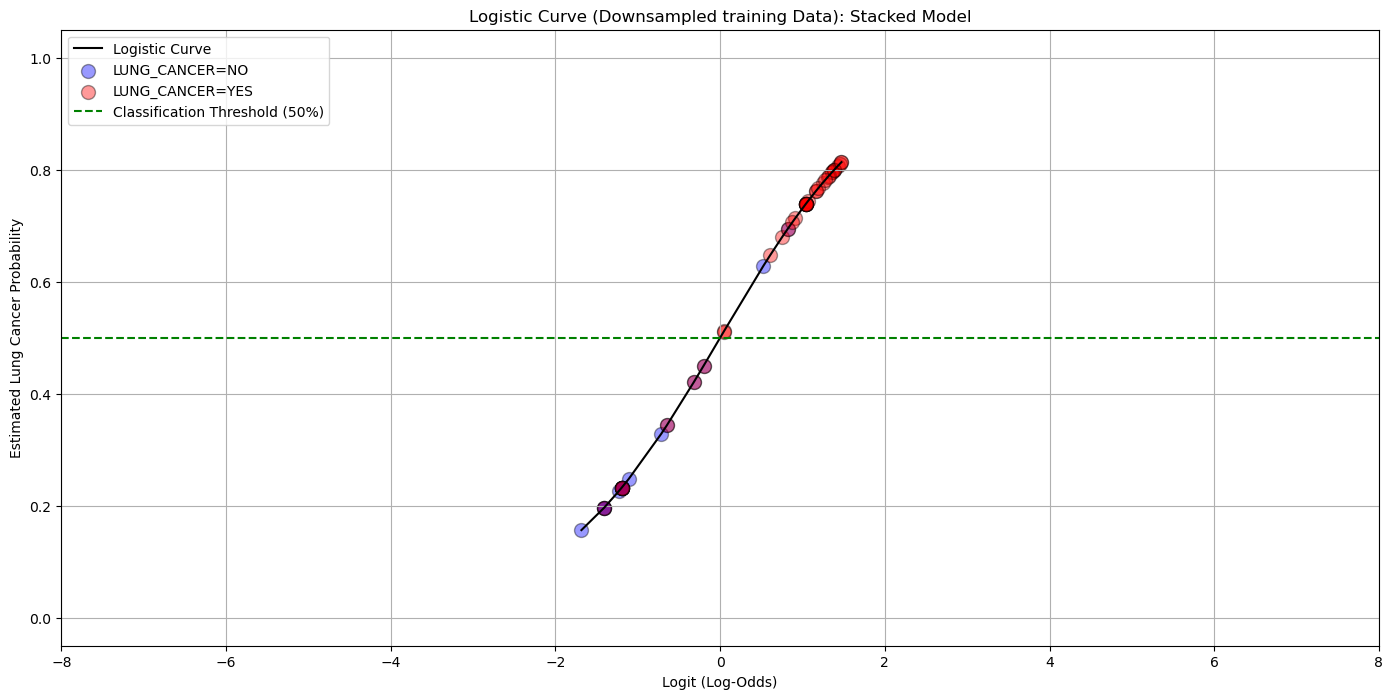

In [195]:
##################################
# Plotting the estimated logistic curve
# using the logit values
# and estimated probabilities
# obtained from the training data
##################################
plt.figure(figsize=(17, 8))
plt.plot(stacked_unbalanced_class_best_model_downsampled_logit_values_sorted, 
         stacked_unbalanced_class_best_model_downsampled_probabilities_sorted, label='Logistic Curve', color='black')
plt.ylim(-0.05, 1.05)
plt.xlim(-8.00, 8.00)
target_0_indices = y_train_cnn == 0
target_1_indices = y_train_cnn == 1
plt.scatter(stacked_unbalanced_class_best_model_downsampled_logit_values[target_0_indices], 
            stacked_unbalanced_class_best_model_downsampled_probabilities[target_0_indices], 
            color='blue', alpha=0.40, s=100, marker= 'o', edgecolor='k', label='LUNG_CANCER=NO')
plt.scatter(stacked_unbalanced_class_best_model_downsampled_logit_values[target_1_indices], 
            stacked_unbalanced_class_best_model_downsampled_probabilities[target_1_indices], 
            color='red', alpha=0.40, s=100, marker='o', edgecolor='k', label='LUNG_CANCER=YES')
plt.axhline(0.5, color='green', linestyle='--', label='Classification Threshold (50%)')
plt.title('Logistic Curve (Downsampled training Data): Stacked Model')
plt.xlabel('Logit (Log-Odds)')
plt.ylabel('Estimated Lung Cancer Probability')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [196]:
##################################
# Saving the best stacked model
# developed from the downsampled training data
################################## 
joblib.dump(stacked_unbalanced_class_best_model_downsampled, 
            os.path.join("..", MODELS_PATH, "stacked_unbalanced_class_best_model_downsampled.pkl"))

['..\\models\\stacked_unbalanced_class_best_model_downsampled.pkl']

### 1.6.7 Model Selection <a class="anchor" id="1.6.7"></a>

### 1.6.8 Model Testing <a class="anchor" id="1.6.8"></a>

In [197]:
##################################
# Evaluating the F1 scores
# on the test data
##################################
individual_unbalanced_class_best_model_original_f1_test = f1_score(y_test, individual_unbalanced_class_best_model_original.predict(X_test))

In [198]:
##################################
# Summarizing the F1 score results
##################################
print(f"F1 Score of the Best Model (with Original Train Data) on Test Data: {individual_unbalanced_class_best_model_original_f1_test:.4f}")

F1 Score of the Best Model (with Original Train Data) on Test Data: 0.9048


### 1.6.9 Model Inference | Interpretation <a class="anchor" id="1.6.7"></a>

# 3. References <a class="anchor" id="References"></a>

* **[Book]** [Data Preparation for Machine Learning: Data Cleaning, Feature Selection, and Data Transforms in Python](https://machinelearningmastery.com/data-preparation-for-machine-learning/) by Jason Brownlee
* **[Book]** [Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/) by Max Kuhn and Kjell Johnson
* **[Book]** [Feature Engineering for Machine Learning](https://www.oreilly.com/library/view/feature-engineering-for/9781491953235/) by Alice Zheng and Amanda Casari
* **[Book]** [Applied Predictive Modeling](https://link.springer.com/book/10.1007/978-1-4614-6849-3?page=1) by Max Kuhn and Kjell Johnson
* **[Book]** [Data Mining: Practical Machine Learning Tools and Techniques](https://www.sciencedirect.com/book/9780123748560/data-mining-practical-machine-learning-tools-and-techniques?via=ihub=) by Ian Witten, Eibe Frank, Mark Hall and Christopher Pal 
* **[Book]** [Data Cleaning](https://dl.acm.org/doi/book/10.1145/3310205) by Ihab Ilyas and Xu Chu
* **[Book]** [Data Wrangling with Python](https://www.oreilly.com/library/view/data-wrangling-with/9781491948804/) by Jacqueline Kazil and Katharine Jarmul
* **[Book]** [Regression Modeling Strategies](https://link.springer.com/book/10.1007/978-1-4757-3462-1) by Frank Harrell
* **[Book]** [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning) by Gautam Kunapuli
* **[Book]** [Imbalanced Classification with Python: Better Metrics, Balance Skewed Classes, Cost-Sensitive Learning](https://machinelearningmastery.com/imbalanced-classification-with-python/) by Jason Brownlee
* **[Python Library API]** [NumPy](https://numpy.org/doc/) by NumPy Team
* **[Python Library API]** [pandas](https://pandas.pydata.org/docs/) by Pandas Team
* **[Python Library API]** [seaborn](https://seaborn.pydata.org/) by Seaborn Team
* **[Python Library API]** [matplotlib.pyplot](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) by MatPlotLib Team
* **[Python Library API]** [itertools](https://docs.python.org/3/library/itertools.html) by Python Team
* **[Python Library API]** [operator](https://docs.python.org/3/library/operator.html) by Python Team
* **[Python Library API]** [sklearn.experimental](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.experimental) by Scikit-Learn Team
* **[Python Library API]** [sklearn.impute](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute) by Scikit-Learn Team
* **[Python Library API]** [sklearn.linear_model](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) by Scikit-Learn Team
* **[Python Library API]** [sklearn.preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) by Scikit-Learn Team
* **[Python Library API]** [scipy](https://docs.scipy.org/doc/scipy/) by SciPy Team
* **[Python Library API]** [sklearn.tree](https://scikit-learn.org/stable/modules/tree.html) by Scikit-Learn Team
* **[Python Library API]** [sklearn.ensemble](https://scikit-learn.org/stable/modules/ensemble.html) by Scikit-Learn Team
* **[Python Library API]** [sklearn.svm](https://scikit-learn.org/stable/modules/svm.html) by Scikit-Learn Team
* **[Python Library API]** [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) by Scikit-Learn Team
* **[Python Library API]** [sklearn.model_selection](https://scikit-learn.org/stable/model_selection.html) by Scikit-Learn Team
* **[Python Library API]** [imblearn.over_sampling](https://imbalanced-learn.org/stable/over_sampling.html) by Imbalanced-Learn Team
* **[Python Library API]** [imblearn.under_sampling](https://imbalanced-learn.org/stable/under_sampling.html) by Imbalanced-Learn Team
* **[Article]** [Step-by-Step Exploratory Data Analysis (EDA) using Python](https://www.analyticsvidhya.com/blog/2022/07/step-by-step-exploratory-data-analysis-eda-using-python/#:~:text=Exploratory%20Data%20Analysis%20(EDA)%20with,distributions%20using%20Python%20programming%20language.) by Malamahadevan Mahadevan (Analytics Vidhya)
* **[Article]** [Exploratory Data Analysis in Python — A Step-by-Step Process](https://towardsdatascience.com/exploratory-data-analysis-in-python-a-step-by-step-process-d0dfa6bf94ee) by Andrea D'Agostino (Towards Data Science)
* **[Article]** [Exploratory Data Analysis with Python](https://medium.com/@douglas.rochedo/exploratory-data-analysis-with-python-78b6c1d479cc) by Douglas Rocha (Medium)
* **[Article]** [4 Ways to Automate Exploratory Data Analysis (EDA) in Python](https://builtin.com/data-science/EDA-python) by Abdishakur Hassan (BuiltIn)
* **[Article]** [10 Things To Do When Conducting Your Exploratory Data Analysis (EDA)](https://www.analyticsvidhya.com) by Alifia Harmadi (Medium)
* **[Article]** [How to Handle Missing Data with Python](https://machinelearningmastery.com/handle-missing-data-python/) by Jason Brownlee (Machine Learning Mastery)
* **[Article]** [Statistical Imputation for Missing Values in Machine Learning](https://machinelearningmastery.com/statistical-imputation-for-missing-values-in-machine-learning/) by Jason Brownlee (Machine Learning Mastery)
* **[Article]** [Imputing Missing Data with Simple and Advanced Techniques](https://towardsdatascience.com/imputing-missing-data-with-simple-and-advanced-techniques-f5c7b157fb87) by Idil Ismiguzel (Towards Data Science)
* **[Article]** [Missing Data Imputation Approaches | How to handle missing values in Python](https://www.machinelearningplus.com/machine-learning/missing-data-imputation-how-to-handle-missing-values-in-python/) by Selva Prabhakaran (Machine Learning +)
* **[Article]** [Master The Skills Of Missing Data Imputation Techniques In Python(2022) And Be Successful](https://medium.com/analytics-vidhya/a-quick-guide-on-missing-data-imputation-techniques-in-python-2020-5410f3df1c1e) by Mrinal Walia (Analytics Vidhya)
* **[Article]** [How to Preprocess Data in Python](https://builtin.com/machine-learning/how-to-preprocess-data-python) by Afroz Chakure (BuiltIn)
* **[Article]** [Easy Guide To Data Preprocessing In Python](https://www.kdnuggets.com/2020/07/easy-guide-data-preprocessing-python.html) by Ahmad Anis (KDNuggets)
* **[Article]** [Data Preprocessing in Python](https://towardsdatascience.com/data-preprocessing-in-python-b52b652e37d5) by Tarun Gupta (Towards Data Science)
* **[Article]** [Data Preprocessing using Python](https://medium.com/@suneet.bhopal/data-preprocessing-using-python-1bfee9268fb3) by Suneet Jain (Medium)
* **[Article]** [Data Preprocessing in Python](https://medium.com/@abonia/data-preprocessing-in-python-1f90d95d44f4) by Abonia Sojasingarayar (Medium)
* **[Article]** [Data Preprocessing in Python](https://medium.datadriveninvestor.com/data-preprocessing-3cd01eefd438) by Afroz Chakure (Medium)
* **[Article]** [Detecting and Treating Outliers | Treating the Odd One Out!](https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/) by Harika Bonthu (Analytics Vidhya)
* **[Article]** [Outlier Treatment with Python](https://medium.com/analytics-vidhya/outlier-treatment-9bbe87384d02) by Sangita Yemulwar (Analytics Vidhya)
* **[Article]** [A Guide to Outlier Detection in Python](https://builtin.com/data-science/outlier-detection-python) by Sadrach Pierre (BuiltIn)
* **[Article]** [How To Find Outliers in Data Using Python (and How To Handle Them)](https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/) by Eric Kleppen (Career Foundry)
* **[Article]** [Statistics in Python — Collinearity and Multicollinearity](https://towardsdatascience.com/statistics-in-python-collinearity-and-multicollinearity-4cc4dcd82b3f) by Wei-Meng Lee (Towards Data Science)
* **[Article]** [Understanding Multicollinearity and How to Detect it in Python](https://towardsdatascience.com/everything-you-need-to-know-about-multicollinearity-2f21f082d6dc) by Terence Shin (Towards Data Science)
* **[Article]** [A Python Library to Remove Collinearity](https://www.yourdatateacher.com/2021/06/28/a-python-library-to-remove-collinearity/) by Gianluca Malato (Your Data Teacher)
* **[Article]** [How to Normalize Data Using scikit-learn in Python](https://www.digitalocean.com/community/tutorials/normalize-data-in-python) by Jayant Verma (Digital Ocean)
* **[Article]** [What are Categorical Data Encoding Methods | Binary Encoding](https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/) by Shipra Saxena  (Analytics Vidhya)
* **[Article]** [Guide to Encoding Categorical Values in Python](https://pbpython.com/categorical-encoding.html) by Chris Moffitt (Practical Business Python)
* **[Article]** [Categorical Data Encoding Techniques in Python: A Complete Guide](https://soumenatta.medium.com/categorical-data-encoding-techniques-in-python-a-complete-guide-a913aae19a22) by Soumen Atta (Medium)
* **[Article]** [Categorical Feature Encoding Techniques](https://towardsdatascience.com/categorical-encoding-techniques-93ebd18e1f24) by Tara Boyle (Medium)
* **[Article]** [Ordinal and One-Hot Encodings for Categorical Data](https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/) by Jason Brownlee (Machine Learning Mastery)
* **[Article]** [Hypothesis Testing with Python: Step by Step Hands-On Tutorial with Practical Examples](https://towardsdatascience.com/hypothesis-testing-with-python-step-by-step-hands-on-tutorial-with-practical-examples-e805975ea96e) by Ece Işık Polat (Towards Data Science)
* **[Article]** [17 Statistical Hypothesis Tests in Python (Cheat Sheet)](https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/) by Jason Brownlee (Machine Learning Mastery)
* **[Article]** [A Step-by-Step Guide to Hypothesis Testing in Python using Scipy](https://medium.com/@gabriel_renno/a-step-by-step-guide-to-hypothesis-testing-in-python-using-scipy-8eb5b696ab07) by Gabriel Rennó (Medium)
* **[Article]** [How to Evaluate Classification Models in Python: A Beginner's Guide](https://builtin.com/data-science/evaluating-classification-models) by Sadrach Pierre (BuiltIn)
* **[Article]** [Machine Learning Classifiers Comparison with Python](https://towardsdatascience.com/machine-learning-classifiers-comparison-with-python-33149aecdbca) by Roberto Salazar (Towards Data Science)
* **[Article]** [Top 6 Machine Learning Algorithms for Classification](https://towardsdatascience.com/top-machine-learning-algorithms-for-classification-2197870ff501) by Destin Gong (Towards Data Science)
* **[Article]** [Metrics For Evaluating Machine Learning Classification Models](https://towardsdatascience.com/metrics-for-evaluating-machine-learning-classification-models-python-example-59b905e079a5) by Cory Maklin (Towards Data Science)
* **[Article]** [Evaluation Metrics for Classification Problems with Implementation in Python](https://medium.com/analytics-vidhya/evaluation-metrics-for-classification-problems-with-implementation-in-python-a20193b4f2c3) by Venu Gopal Kadamba (Medium)
* **[Article]** [Tour of Evaluation Metrics for Imbalanced Classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/) by Jason Brownlee (Machine Learning Mastery)
* **[Article]** [Metrics To Evaluate Machine Learning Algorithms in Python](https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/) by Jason Brownlee (Machine Learning Mastery)
* **[Article]** [How To Compare Machine Learning Algorithms in Python with scikit-learn](https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/) by Jason Brownlee (Machine Learning Mastery)
* **[Article]** [How to Deal With Imbalanced Classification and Regression Data](https://neptune.ai/blog/how-to-deal-with-imbalanced-classification-and-regression-data) by Prince Canuma (Neptune.AI)
* **[Article]** [Random Oversampling and Undersampling for Imbalanced Classification](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/) by Jason Brownlee (Machine Learning Mastery)
* **[Article]** [How to Handle Imbalance Data and Small Training Sets in ML](https://towardsdatascience.com/how-to-handle-imbalance-data-and-small-training-sets-in-ml-989f8053531d) by Ege Hosgungor (Towards Data Science)
* **[Article]** [Class Imbalance Strategies — A Visual Guide with Code](https://towardsdatascience.com/class-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a) by Travis Tang (Towards Data Science)
* **[Article]** [Machine Learning: How to Handle Class Imbalance](https://medium.com/analytics-vidhya/machine-learning-how-to-handle-class-imbalance-920e48c3e970) by Ken Hoffman (Medium)
* **[Article]** [Handling Class Imbalance in Machine Learning](https://medium.com/mlearning-ai/handling-class-imbalance-in-machine-learning-cb1473e825ce) by Okan Yenigün (Medium)
* **[Article]** [Undersampling Algorithms for Imbalanced Classification](https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/) by Jason Brownlee (Machine Learning Mastery)
* **[Article]** [Condensed Nearest Neighbor Rule Undersampling (CNN) & TomekLinks](https://bobrupakroy.medium.com/condensed-nearest-neighbor-rule-undersampling-cnn-380c0d84ca88) by Rupak Roy (Medium)
* **[Article]** [CNN (Condensed Nearest Neighbors)](https://abhic159.medium.com/cnn-condensed-nearest-neighbors-3261bd0c39fb) by Abhishek (Medium)
* **[Article]** [Synthetic Minority Over-sampling TEchnique (SMOTE)](https://medium.com/@corymaklin/synthetic-minority-over-sampling-technique-smote-7d419696b88c) by Cory Maklin (Medium)
* **[Article]** [SMOTE for Imbalanced Classification with Python](https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/) by Swastik Satpathy (Analytics Vidhya)
* **[Article]** [An Introduction to SMOTE](https://www.kdnuggets.com/2022/11/introduction-smote.html#:~:text=SMOTE%20(Synthetic%20Minority%20Oversampling%20Technique)%20is%20an%20oversampling%20method%20of,a%20point%20along%20that%20line.) by Abid Ali Awan (KD Nuggets)
* **[Article]** [A Comprehensive Guide to Ensemble Learning (with Python codes)](https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/) by Aishwarya Singh (Analytics Vidhya)
* **[Article]** [Stacked Ensembles — Improving Model Performance on a Higher Level](https://towardsdatascience.com/stacked-ensembles-improving-model-performance-on-a-higher-level-99ffc4ea5523) by Yenwee Lim (Towards Data Science)
* **[Article]** [Stacking to Improve Model Performance: A Comprehensive Guide on Ensemble Learning in Python](https://medium.com/@brijesh_soni/stacking-to-improve-model-performance-a-comprehensive-guide-on-ensemble-learning-in-python-9ed53c93ce28) by Brijesh Soni (Medium)
* **[Article]** [Stacking Ensemble Machine Learning With Python](https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/) by Jason Brownlee (Machine Learning Mastery)
* **[Publication]** [Data Quality for Machine Learning Tasks](https://journals.sagepub.com/doi/10.1177/0962280206074463) by Nitin Gupta, Shashank Mujumdar, Hima Patel, Satoshi Masuda, Naveen Panwar, Sambaran Bandyopadhyay, Sameep Mehta, Shanmukha Guttula, Shazia Afzal, Ruhi Sharma Mittal and Vitobha Munigala (KDD ’21: Proceedings of the 27th ACM SIGKDD Conference on Knowledge Discovery & Data Mining)
* **[Publication]** [Overview and Importance of Data Quality for Machine Learning Tasks](https://dl.acm.org/doi/10.1145/3394486.3406477) by Abhinav Jain, Hima Patel, Lokesh Nagalapatti, Nitin Gupta, Sameep Mehta, Shanmukha Guttula, Shashank Mujumdar, Shazia Afzal, Ruhi Sharma Mittal and Vitobha Munigala (KDD ’20: Proceedings of the 26th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining)
* **[Publication]** [Mathematical Contributions to the Theory of Evolution: Regression, Heredity and Panmixia](https://royalsocietypublishing.org/doi/10.1098/rsta.1896.0007) by Karl Pearson (Royal Society)
* **[Publication]** [The Probable Error of the Mean](http://seismo.berkeley.edu/~kirchner/eps_120/Odds_n_ends/Students_original_paper.pdf) by Student (Biometrika)
* **[Publication]** [On the Criterion That a Given System of Deviations from the Probable in the Case of a Correlated System of Variables is Such That It can Be Reasonably Supposed to Have Arisen From Random Sampling](https://www.tandfonline.com/doi/abs/10.1080/14786440009463897) by Karl Pearson (Philosophical Magazine)
* **[Publication]** [The Origins of Logistic Regression](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=360300) by JS Cramer (Econometrics eJournal)
* **[Publication]** [Classification and Regression Trees](https://www.semanticscholar.org/paper/Classification-and-Regression-Trees-Breiman-Friedman/8017699564136f93af21575810d557dba1ee6fc6) by Leo Breiman, Jerome Friedman, Richard Olshen and Charles Stone (Computer Science)
* **[Publication]** [Random Forest](https://link.springer.com/article/10.1023/A:1010933404324) by Leo Breiman (Machine Learning)
* **[Publication]** [A Training Algorithm for Optimal Margin Classifiers](https://dl.acm.org/doi/10.1145/130385.130401) by Bernhard Boser, Isabelle Guyon and Vladimir Vapnik (Proceedings of the Fifth Annual Workshop on Computational Learning Theory)
* **[Publication]** [SMOTE: Synthetic Minority Over-Sampling Technique](https://dl.acm.org/doi/10.5555/1622407.1622416) by Nitesh Chawla, Kevin Bowyer, Lawrence Hall and Philip Kegelmeyer (Journal of Artificial Intelligence Research)
* **[Publication]** [The Condensed Nearest Neighbor Rule](https://ieeexplore.ieee.org/document/1054155) by Peter Hart (IEEE Transactions on Information Theory)
* **[Course]** [DataCamp Python Data Analyst Certificate](https://app.datacamp.com/learn/career-tracks/data-analyst-with-python) by DataCamp Team (DataCamp)
* **[Course]** [DataCamp Python Associate Data Scientist Certificate](https://app.datacamp.com/learn/career-tracks/associate-data-scientist-in-python) by DataCamp Team (DataCamp)
* **[Course]** [DataCamp Python Data Scientist Certificate](https://app.datacamp.com/learn/career-tracks/data-scientist-in-python) by DataCamp Team (DataCamp)
* **[Course]** [DataCamp Machine Learning Scientist Certificate](https://app.datacamp.com/learn/career-tracks/machine-learning-scientist-with-python) by DataCamp Team (DataCamp)
* **[Course]** [IBM Data Analyst Professional Certificate](https://www.coursera.org/professional-certificates/ibm-data-analyst) by IBM Team (Coursera)
* **[Course]** [IBM Data Science Professional Certificate](https://www.coursera.org/professional-certificates/ibm-data-science) by IBM Team (Coursera)
* **[Course]** [IBM Machine Learning Professional Certificate](https://www.coursera.org/professional-certificates/ibm-machine-learning) by IBM Team (Coursera)

In [199]:
from IPython.display import display, HTML
display(HTML("<style>.rendered_html { font-size: 15px; font-family: 'Trebuchet MS'; }</style>"))